# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [1]:
# Import essential libraries for data manipulation and analysis

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical analysis and modeling
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression



## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [2]:
# Importing the file porter_data_1.csv
# Import the CSV file
df = pd.read_csv(r'C:\Users\ADMIN\Downloads\porter_data_1.csv')

# Quick look at the data
print(df.head())
print(df.info())

   market_id           created_at actual_delivery_time  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:11:17   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:33:25   
2        2.0  2015-02-16 00:11:35  2015-02-16 01:06:35   
3        1.0  2015-02-12 03:36:46  2015-02-12 04:35:46   
4        1.0  2015-01-27 02:12:36  2015-01-27 02:58:36   

   store_primary_category  order_protocol  total_items  subtotal  \
0                       4             1.0            4      3441   
1                      46             2.0            1      1900   
2                      36             3.0            4      4771   
3                      38             1.0            1      1525   
4                      38             1.0            2      3620   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2 

## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [4]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format

# Convert to datetime format
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

# Preview the result
print(df[['created_at', 'actual_delivery_time']].head())


           created_at actual_delivery_time
0 2015-02-06 22:24:17  2015-02-06 23:11:17
1 2015-02-10 21:49:25  2015-02-10 22:33:25
2 2015-02-16 00:11:35  2015-02-16 01:06:35
3 2015-02-12 03:36:46  2015-02-12 04:35:46
4 2015-01-27 02:12:36  2015-01-27 02:58:36


##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [5]:
# Convert categorical features to category type

# Automatically detect likely categorical columns
categorical_cols = [
    'store_primary_category',
    'order_protocol'
    # Add any other columns you know are categorical
]

# Convert them to category type
for col in categorical_cols:
    df[col] = df[col].astype('category')

# Confirm conversion
print(df[categorical_cols].dtypes)


store_primary_category    category
order_protocol            category
dtype: object


#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [6]:
# Calculate time taken in minutes
df['time_taken_minutes'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60

# Quick check
print(df[['created_at', 'actual_delivery_time', 'time_taken_minutes']].head())

           created_at actual_delivery_time  time_taken_minutes
0 2015-02-06 22:24:17  2015-02-06 23:11:17                47.0
1 2015-02-10 21:49:25  2015-02-10 22:33:25                44.0
2 2015-02-16 00:11:35  2015-02-16 01:06:35                55.0
3 2015-02-12 03:36:46  2015-02-12 04:35:46                59.0
4 2015-01-27 02:12:36  2015-01-27 02:58:36                46.0


##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [7]:
# Extract the hour and day of week from the 'created_at' timestamp
df['order_hour'] = df['created_at'].dt.hour
df['order_dayofweek'] = df['created_at'].dt.dayofweek  # Monday=0, Sunday=6

# Create a categorical feature 'isWeekend'
df['isWeekend'] = df['order_dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

# Quick check
print(df[['created_at', 'order_hour', 'order_dayofweek', 'isWeekend']].head())


           created_at  order_hour  order_dayofweek  isWeekend
0 2015-02-06 22:24:17          22                4          0
1 2015-02-10 21:49:25          21                1          0
2 2015-02-16 00:11:35           0                0          0
3 2015-02-12 03:36:46           3                3          0
4 2015-01-27 02:12:36           2                1          0


In [8]:
# Drop unnecessary columns
cols_to_drop = [
    'created_at', 
    'actual_delivery_time'
    # Add more if needed, e.g. IDs or redundant fields
]

df = df.drop(columns=cols_to_drop)

# Quick check
print(df.head())

   market_id store_primary_category order_protocol  total_items  subtotal  \
0        1.0                      4            1.0            4      3441   
1        2.0                     46            2.0            1      1900   
2        2.0                     36            3.0            4      4771   
3        1.0                     38            1.0            1      1525   
4        1.0                     38            1.0            2      3620   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   3             820            1604                    8.0   
3                   1            1525            1525                    5.0   
4                   2            1425            2195                    5.0   

   total_busy_dashers  total_outstanding_orders  distanc

#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [9]:
# Define target variable (y) and features (X)

# Define target variable (time taken in minutes)
y = df['time_taken_minutes']

# Define input features (drop target and any unnecessary columns)
X = df.drop(columns=['time_taken_minutes'])

# Quick check
print("Target shape:", y.shape)
print("Features shape:", X.shape)

Target shape: (175777,)
Features shape: (175777, 15)


##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [10]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Quick check
print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])



Training set size: 140621
Test set size: 35156


## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [11]:
# Define numerical and categorical columns for easy EDA and data manipulation

# Define numerical columns
numerical_cols = [
    'total_items',
    'subtotal',
    'num_distinct_items',
    'min_item_price',
    'max_item_price',
    'total_onshift_dashers',
    'total_busy_dashers',
    'total_outstanding_orders',
    'distance',
    'time_taken_minutes',
    'order_hour',
    'order_dayofweek'
]

# Define categorical columns
categorical_cols = [
    'market_id',
    'store_primary_category',
    'order_protocol',
    'isWeekend'
]

print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)


Numerical columns: ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'time_taken_minutes', 'order_hour', 'order_dayofweek']
Categorical columns: ['market_id', 'store_primary_category', 'order_protocol', 'isWeekend']


##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

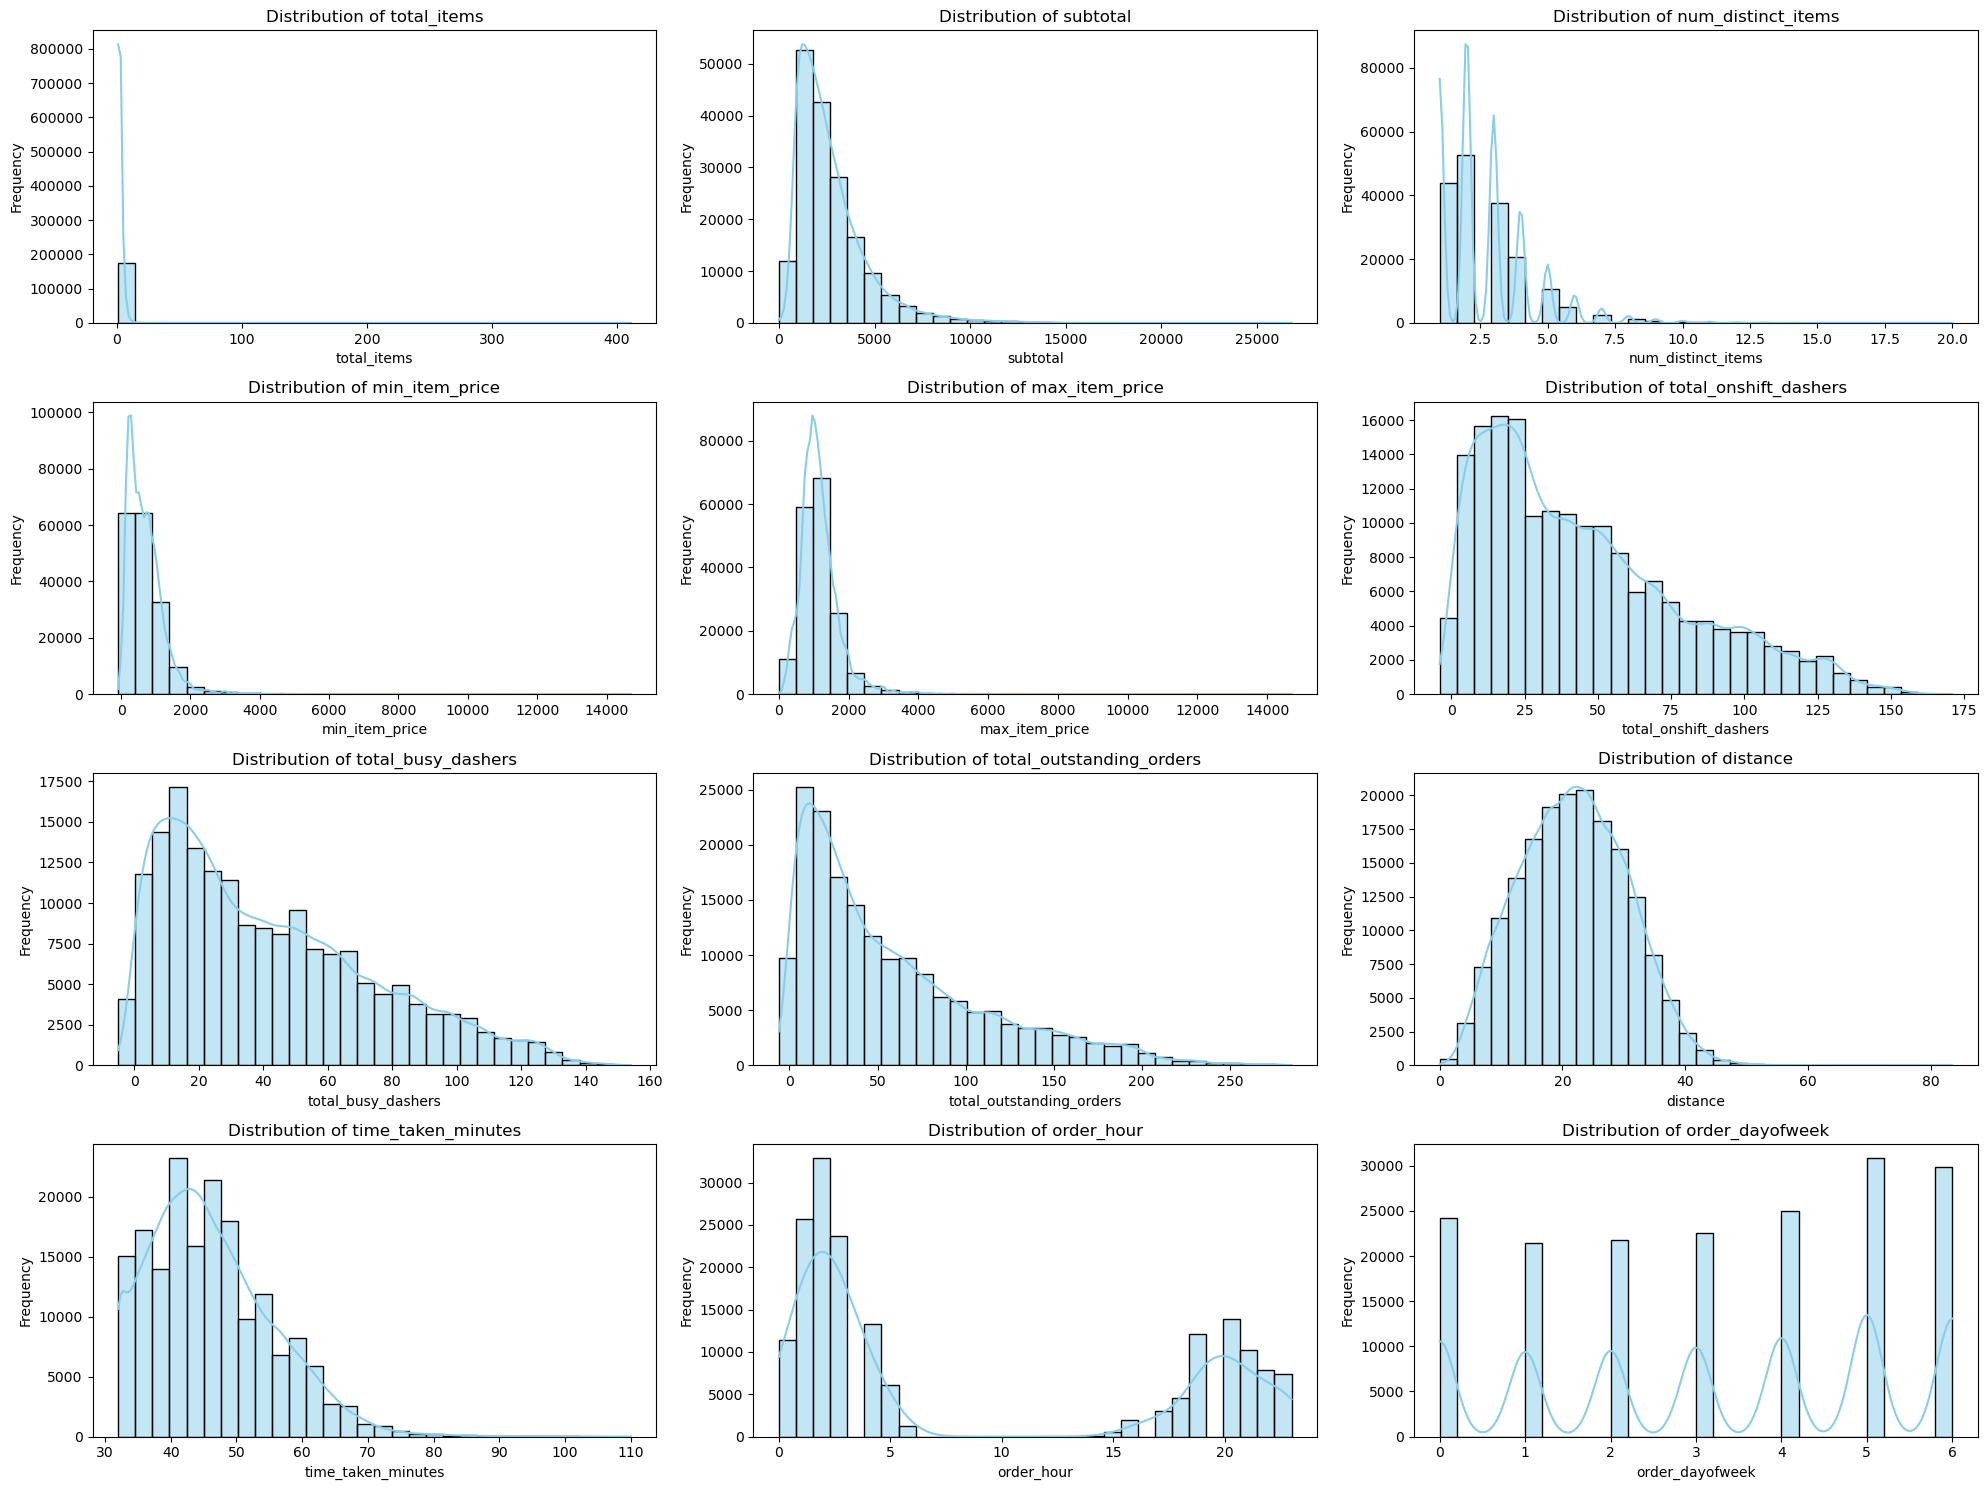

In [12]:
# Plot distributions for all numerical columns
import matplotlib.pyplot as plt
import seaborn as sns

# List of numerical columns
numerical_cols = [
    'total_items',
    'subtotal',
    'num_distinct_items',
    'min_item_price',
    'max_item_price',
    'total_onshift_dashers',
    'total_busy_dashers',
    'total_outstanding_orders',
    'distance',
    'time_taken_minutes',
    'order_hour',
    'order_dayofweek'
]

# Set up grid layout
plt.figure(figsize=(20, 15))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(4, 3, i)  # 4 rows, 3 columns grid
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

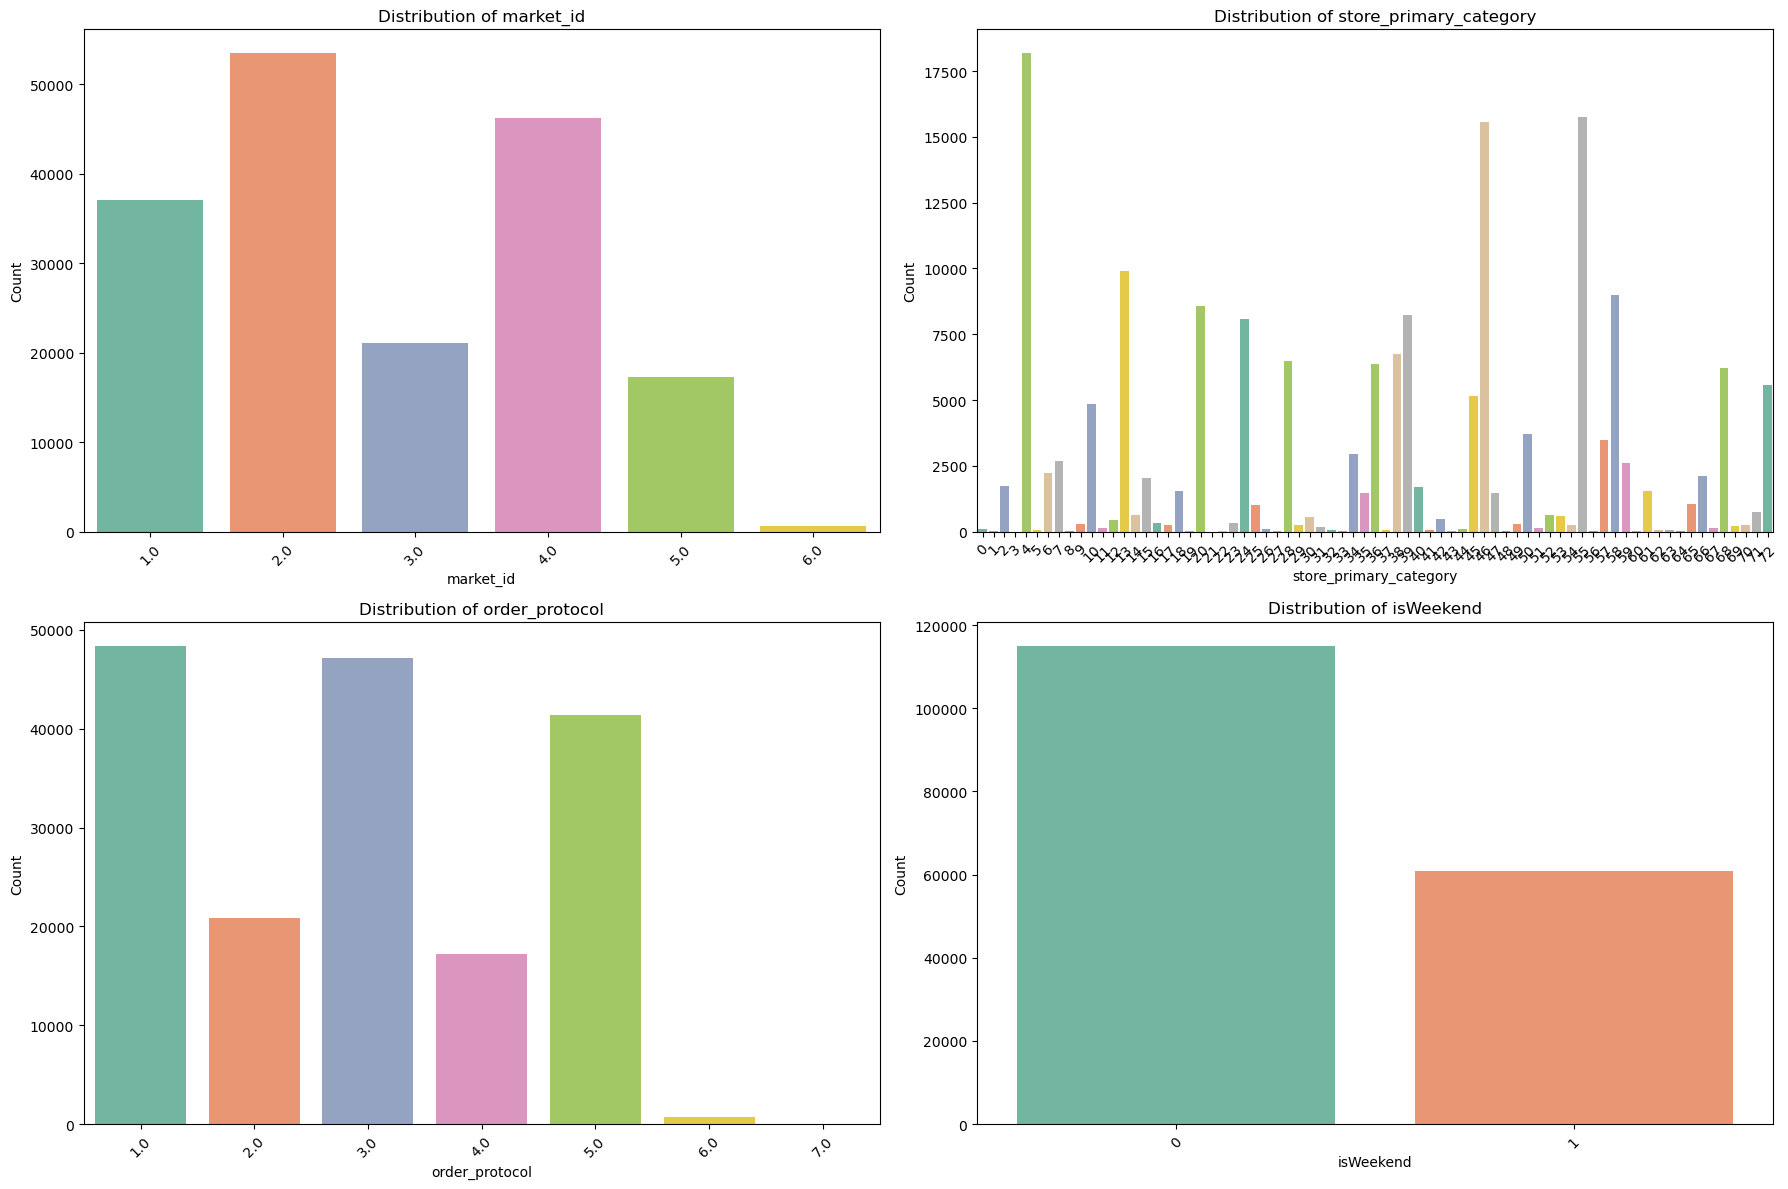

In [15]:
# Distribution of categorical columns
import matplotlib.pyplot as plt
import seaborn as sns

# Define categorical columns in the dataset
categorical_cols = ['market_id', 'store_primary_category', 'order_protocol', 'isWeekend']

# Set up the overall figure size for multiple subplots
plt.figure(figsize=(18, 12))

# Loop through each categorical column and plot its distribution
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 2, i)  # Arrange plots in a 2x2 grid
    # Use countplot to show frequency of each category
    # 'hue=col' ensures palette is applied correctly (avoids FutureWarning)
    sns.countplot(x=df[col], hue=df[col], palette="Set2", legend=False)
    
    # Add title and axis labels for clarity
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    
    # Rotate x-axis labels for readability (especially if categories are long)
    plt.xticks(rotation=45)

# Adjust layout to prevent overlapping text
plt.tight_layout()

# Display all plots
plt.show()



##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

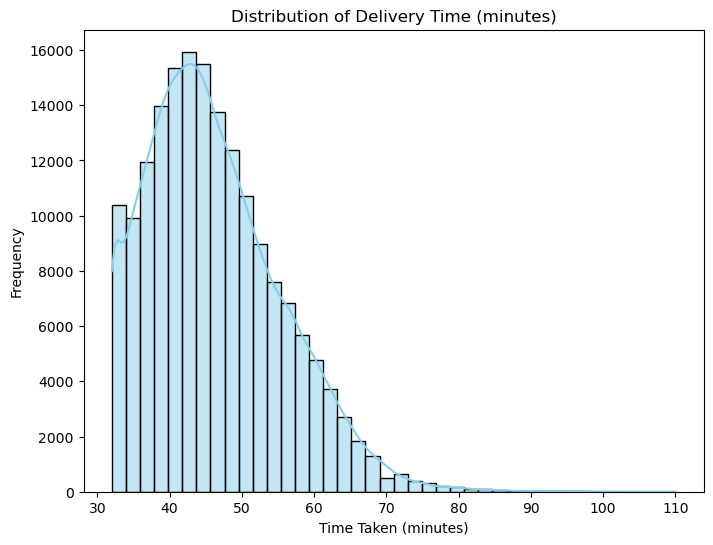

In [16]:
# Distribution of time_taken

import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure size
plt.figure(figsize=(8, 6))

# Plot histogram with KDE overlay to see spread and skewness
sns.histplot(df['time_taken_minutes'], bins=40, kde=True, color='skyblue')

# Add title and axis labels
plt.title('Distribution of Delivery Time (minutes)')
plt.xlabel('Time Taken (minutes)')
plt.ylabel('Frequency')

# Show the plot
plt.show()


#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

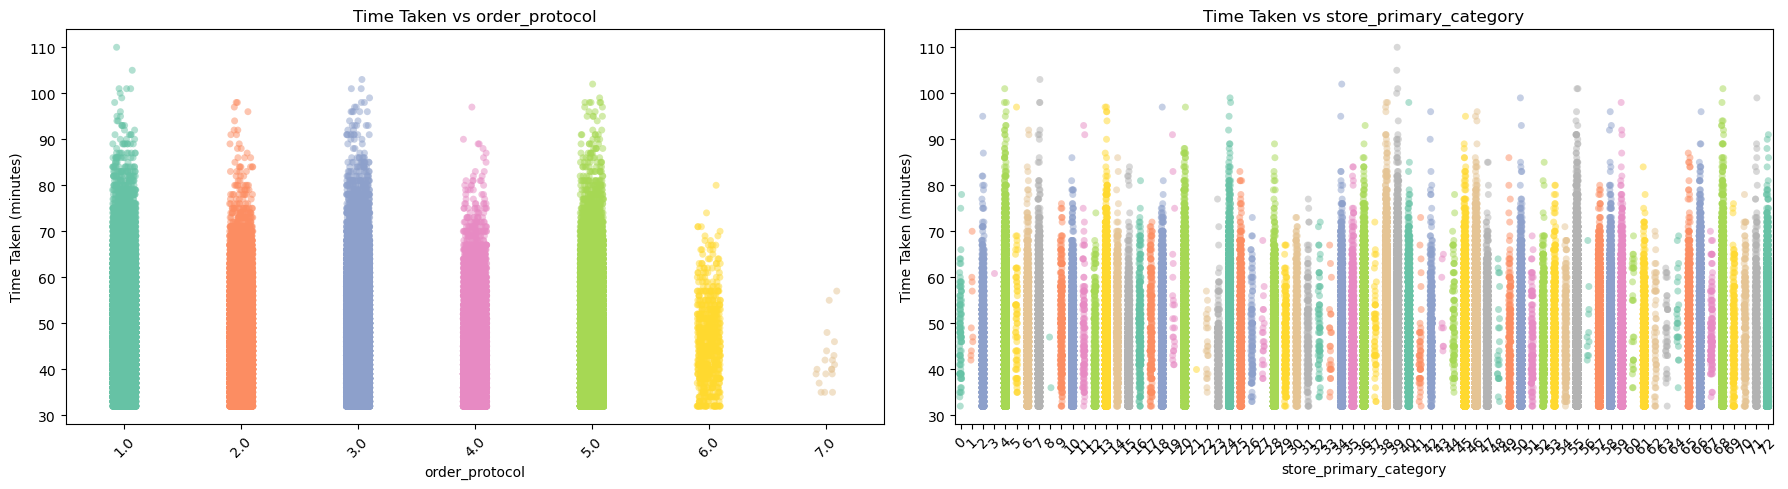

In [20]:
# Scatter plot to visualise the relationship between time_taken and other features

import matplotlib.pyplot as plt
import seaborn as sns

# Define categorical features to compare with time_taken
cat_features = ['order_protocol', 'store_primary_category']

# Set up figure size for categorical plots
plt.figure(figsize=(18, 5))

for i, col in enumerate(cat_features, 1):
    plt.subplot(1, len(cat_features), i)  # Arrange plots in one row
    
    # Stripplot shows distribution of time_taken across categories
    # 'hue=col' ensures palette is applied correctly (avoids FutureWarning)
    # 'legend=False' hides redundant legend since hue is same as x
    sns.stripplot(
        x=df[col], 
        y=df['time_taken_minutes'], 
        hue=df[col], 
        jitter=True, 
        alpha=0.5, 
        palette="Set2", 
        legend=False
    )
    
    # Add title and axis labels
    plt.title(f'Time Taken vs {col}')
    plt.xlabel(col)
    plt.ylabel('Time Taken (minutes)')
    
    # Rotate x-axis labels for readability
    plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display plots
plt.show()


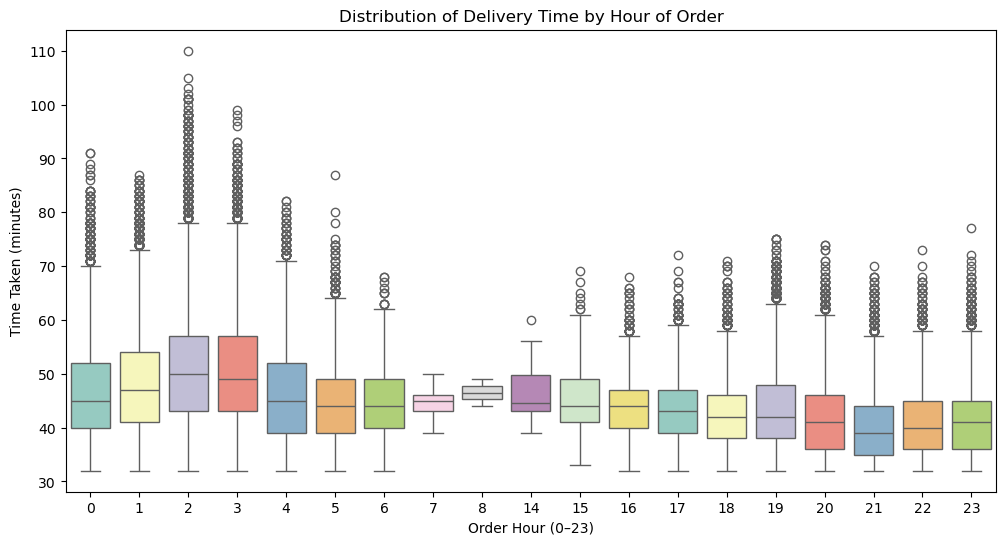

In [22]:
# Show the distribution of time_taken for different hours
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure size
plt.figure(figsize=(12, 6))

# Boxplot to show distribution of time_taken across hours
# 'hue=df["order_hour"]' ensures palette is applied correctly (avoids FutureWarning)
# 'legend=False' hides redundant legend since hue is same as x
sns.boxplot(
    x=df['order_hour'], 
    y=df['time_taken_minutes'], 
    hue=df['order_hour'], 
    palette="Set3", 
    legend=False
)

# Add title and axis labels
plt.title('Distribution of Delivery Time by Hour of Order')
plt.xlabel('Order Hour (0–23)')
plt.ylabel('Time Taken (minutes)')

# Show the plot
plt.show()



#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

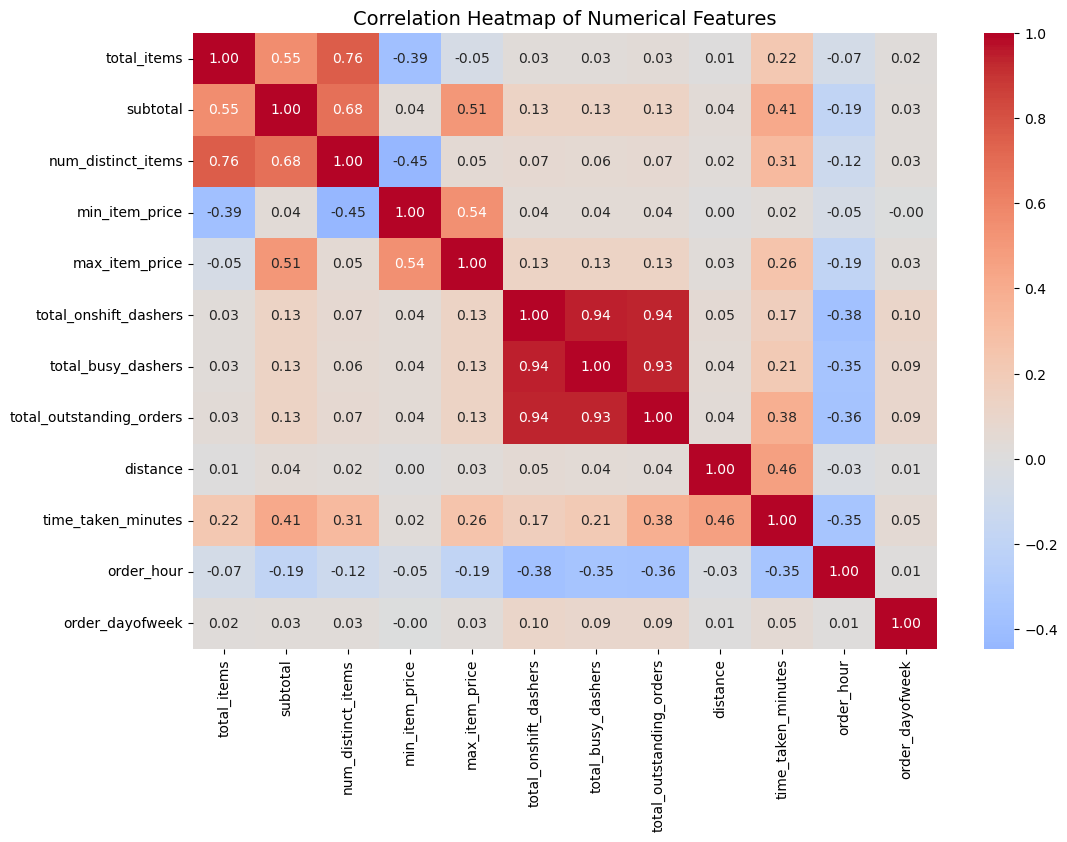

In [23]:
# Plot the heatmap of the correlation matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numerical columns for correlation analysis
numerical_cols = [
    'total_items',
    'subtotal',
    'num_distinct_items',
    'min_item_price',
    'max_item_price',
    'total_onshift_dashers',
    'total_busy_dashers',
    'total_outstanding_orders',
    'distance',
    'time_taken_minutes',
    'order_hour',
    'order_dayofweek'
]

# Compute correlation matrix
corr_matrix = df[numerical_cols].corr()

# Set up the figure size
plt.figure(figsize=(12, 8))

# Plot heatmap of correlations
sns.heatmap(
    corr_matrix, 
    annot=True,        # Show correlation values in cells
    cmap='coolwarm',   # Color scheme for positive/negative correlations
    center=0,          # Center colormap at zero
    fmt=".2f"          # Format correlation values to 2 decimal places
)

# Add title
plt.title('Correlation Heatmap of Numerical Features', fontsize=14)

# Show plot
plt.show()



##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [24]:
# Drop 3-5 weakly correlated columns from training dataset

# Compute correlation of all numerical features with the target variable
corr_with_target = X_train.corrwith(y_train)

# Sort correlations by absolute value (strongest to weakest)
corr_sorted = corr_with_target.abs().sort_values()

# Display correlations for inspection
print("Correlation with target:\n", corr_sorted)

# Select 3–5 weakest correlated features
weak_features = corr_sorted.head(5).index.tolist()

print("Dropping weakly correlated features:", weak_features)

# Drop these features from training and test sets
X_train_reduced = X_train.drop(columns=weak_features)
X_test_reduced = X_test.drop(columns=weak_features)

# Quick check of new shapes
print("Original training shape:", X_train.shape)
print("Reduced training shape:", X_train_reduced.shape)


Correlation with target:
 min_item_price              0.021151
store_primary_category      0.026388
order_dayofweek             0.044897
market_id                   0.075067
isWeekend                   0.137057
order_protocol              0.138070
total_onshift_dashers       0.171828
total_busy_dashers          0.206514
total_items                 0.220804
max_item_price              0.254650
num_distinct_items          0.312510
order_hour                  0.345716
total_outstanding_orders    0.385028
subtotal                    0.413392
distance                    0.461026
dtype: float64
Dropping weakly correlated features: ['min_item_price', 'store_primary_category', 'order_dayofweek', 'market_id', 'isWeekend']
Original training shape: (140621, 15)
Reduced training shape: (140621, 10)


#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

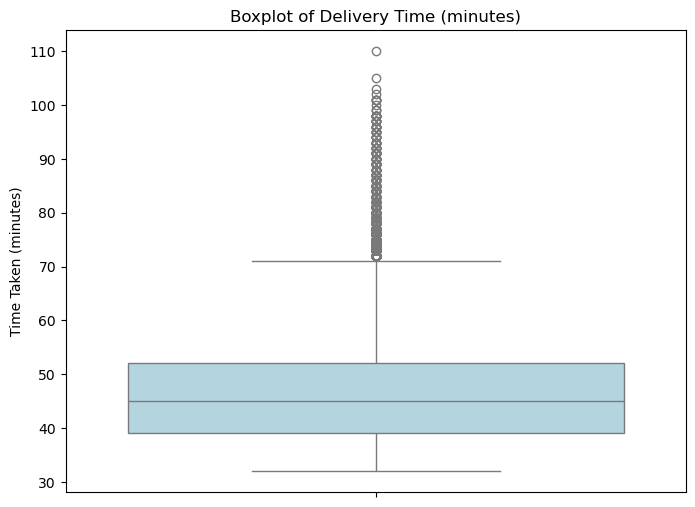

In [25]:
# Boxplot for time_taken
# Set up the figure size
plt.figure(figsize=(8, 6))

# Boxplot for the target variable (time_taken_minutes)
sns.boxplot(
    y=df['time_taken_minutes'],   # Plot delivery time on the y-axis
    color='lightblue'             # Set box color for clarity
)

# Add title and axis labels
plt.title('Boxplot of Delivery Time (minutes)')
plt.ylabel('Time Taken (minutes)')

# Show the plot
plt.show()


##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

In [27]:
# Handle outliers

import numpy as np

# Define numerical columns to check for outliers
numerical_cols = [
    'total_items',
    'subtotal',
    'num_distinct_items',
    'min_item_price',
    'max_item_price',
    'total_onshift_dashers',
    'total_busy_dashers',
    'total_outstanding_orders',
    'distance',
    'time_taken_minutes',
    'order_hour',
    'order_dayofweek'
]

# Function to handle outliers using IQR method
def handle_outliers(df, cols):
    for col in cols:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define lower and upper bounds for acceptable values
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Cap values outside bounds to the boundary values
        df[col] = np.where(df[col] < lower_bound, lower_bound,
                           np.where(df[col] > upper_bound, upper_bound, df[col]))
        
        # Optional: print summary for each column
        print(f"{col}: capped values below {lower_bound:.2f} and above {upper_bound:.2f}")
        
    return df

# Apply outlier handling to numerical columns
df = handle_outliers(df, numerical_cols)

# Quick check of updated distributions
print(df[numerical_cols].describe())


total_items: capped values below -1.00 and above 7.00
subtotal: capped values below -1585.00 and above 6407.00
num_distinct_items: capped values below -2.00 and above 6.00
min_item_price: capped values below -665.50 and above 1906.50
max_item_price: capped values below -95.00 and above 2289.00
total_onshift_dashers: capped values below -56.50 and above 139.50
total_busy_dashers: capped values below -57.00 and above 135.00
total_outstanding_orders: capped values below -85.00 and above 187.00
distance: capped values below -3.78 and above 47.26
time_taken_minutes: capped values below 19.50 and above 71.50
order_hour: capped values below -23.50 and above 44.50
order_dayofweek: capped values below -5.00 and above 11.00
         total_items       subtotal  num_distinct_items  min_item_price  \
count  175777.000000  175777.000000       175777.000000   175777.000000   
mean        3.016163    2607.847016            2.613670      667.611789   
std         1.756566    1532.463086            1.42

## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

In [28]:
# Define numerical and categorical columns for easy EDA and data manipulation

# Define numerical columns for EDA
numerical_cols = [
    'total_items',
    'subtotal',
    'num_distinct_items',
    'min_item_price',
    'max_item_price',
    'total_onshift_dashers',
    'total_busy_dashers',
    'total_outstanding_orders',
    'distance',
    'time_taken_minutes',   # target variable
    'order_hour',
    'order_dayofweek'
]

# Define categorical columns for EDA
categorical_cols = [
    'market_id',
    'store_primary_category',
    'order_protocol',
    'isWeekend'
]

# Quick check: print column groups
print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)


Numerical columns: ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'time_taken_minutes', 'order_hour', 'order_dayofweek']
Categorical columns: ['market_id', 'store_primary_category', 'order_protocol', 'isWeekend']


#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

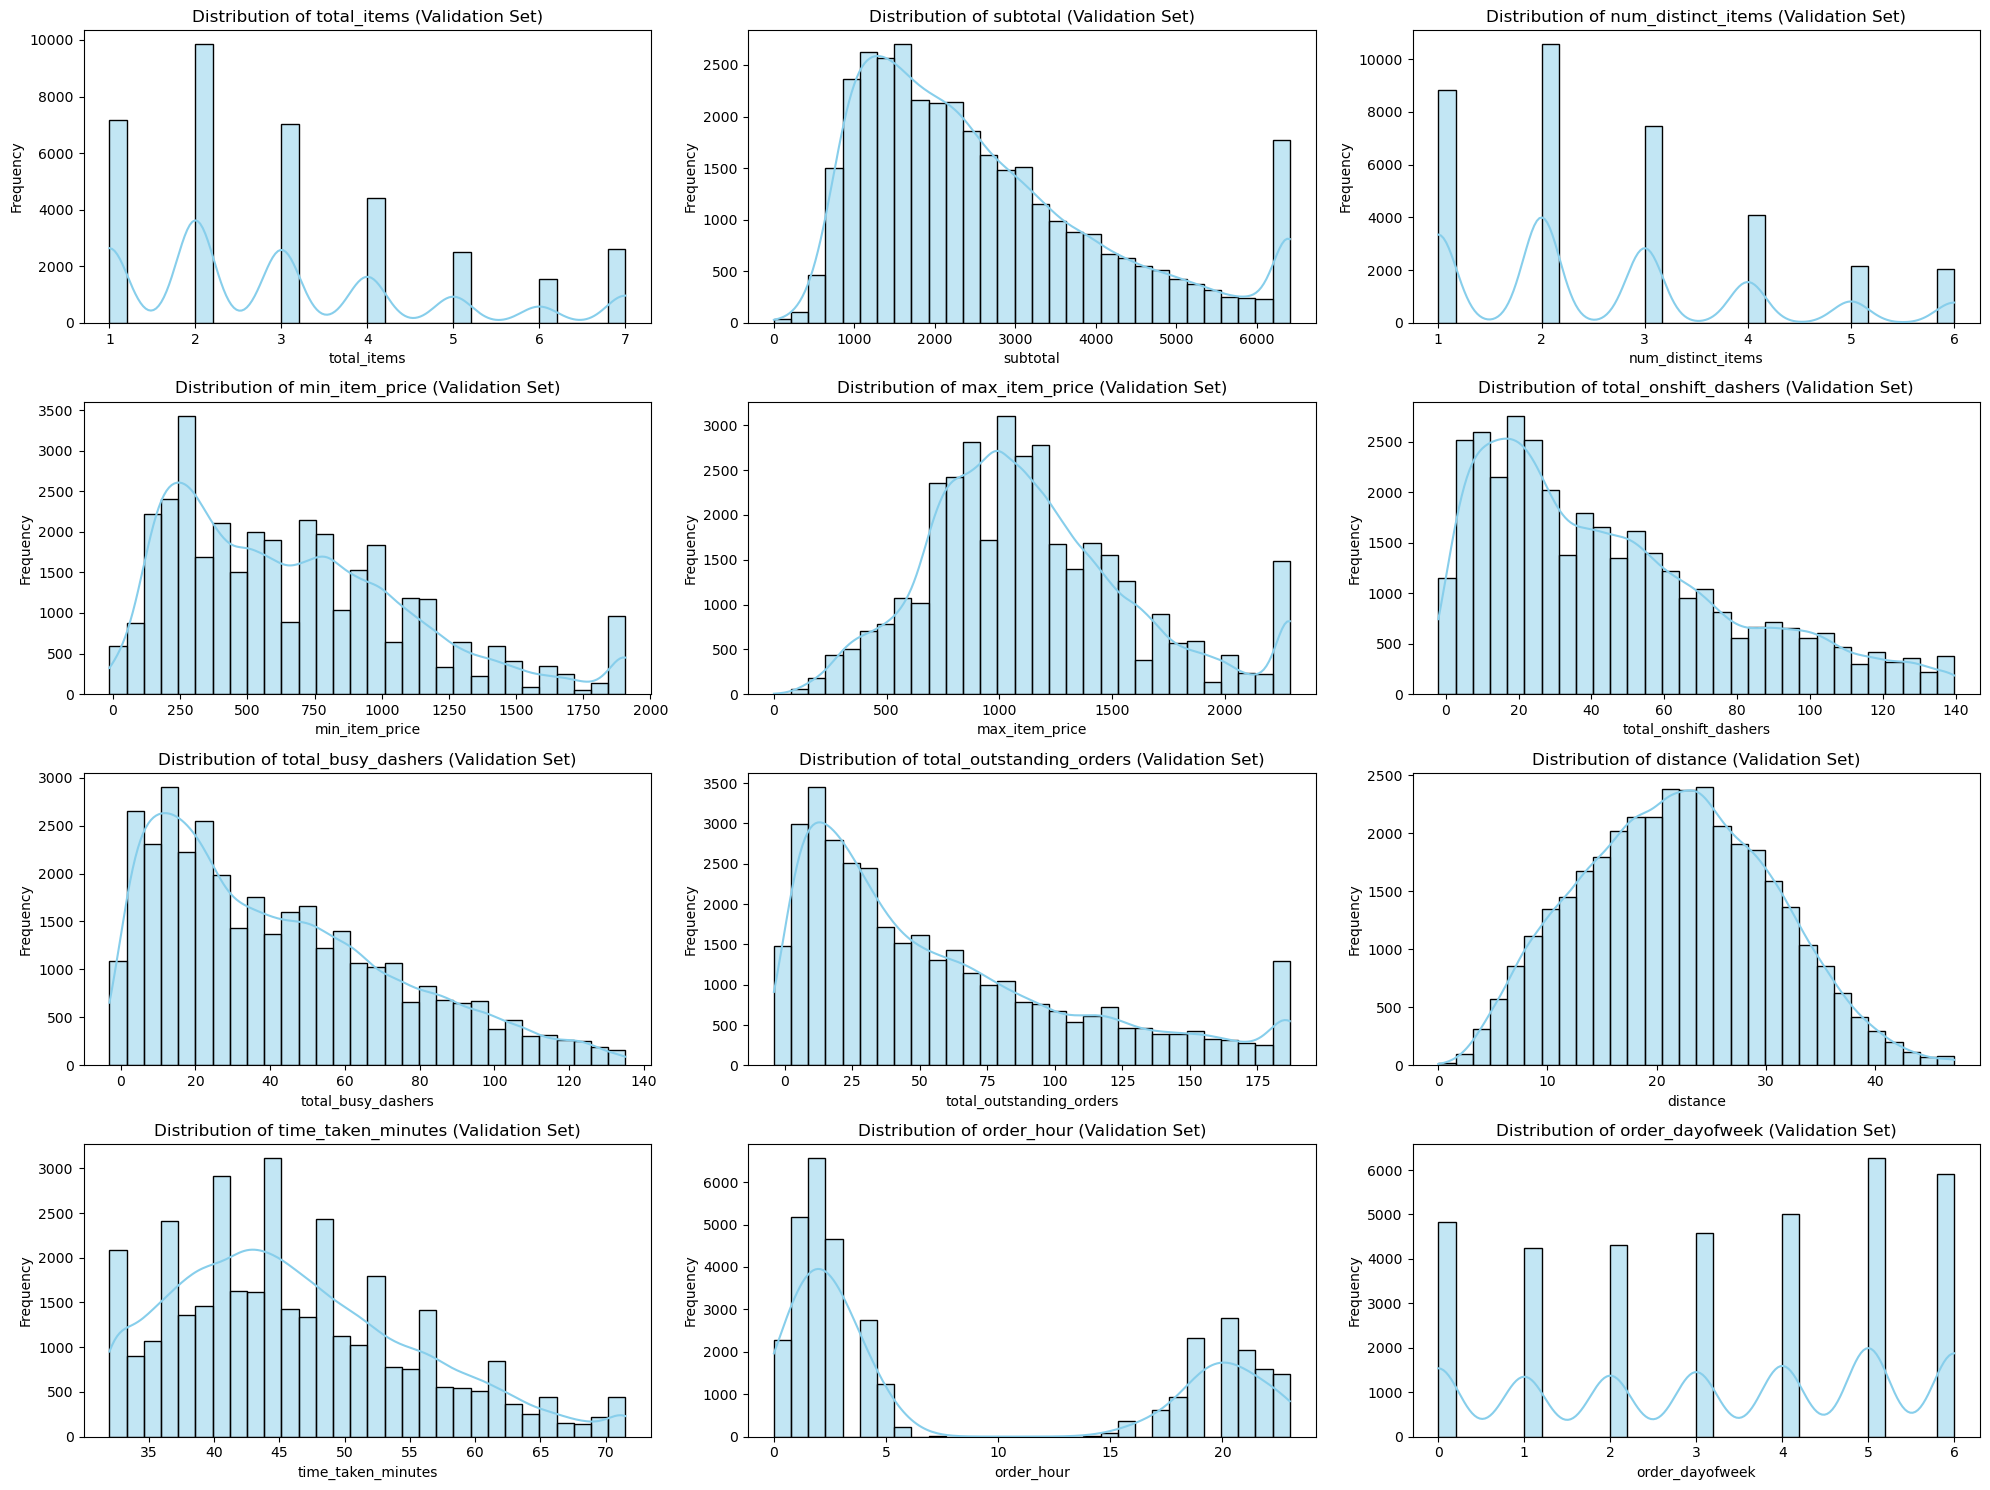

In [30]:
# Plot distributions for all numerical columns

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# -------------------------------
# 1. Define numerical columns
# -------------------------------
numerical_cols = [
    'total_items',
    'subtotal',
    'num_distinct_items',
    'min_item_price',
    'max_item_price',
    'total_onshift_dashers',
    'total_busy_dashers',
    'total_outstanding_orders',
    'distance',
    'time_taken_minutes',   # target variable
    'order_hour',
    'order_dayofweek'
]

# -------------------------------
# 2. Split dataset into train/validation
# -------------------------------
X = df.drop(columns=['time_taken_minutes'])   # features
y = df['time_taken_minutes']                  # target

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -------------------------------
# 3. Plot distributions for numerical columns in validation set
# -------------------------------
plt.figure(figsize=(20, 15))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(4, 3, i)  # Arrange plots in a 4x3 grid
    
    # If column is target, use y_val; else use X_val
    if col == 'time_taken_minutes':
        sns.histplot(y_val, kde=True, bins=30, color='skyblue')
    else:
        sns.histplot(X_val[col], kde=True, bins=30, color='skyblue')
    
    plt.title(f'Distribution of {col} (Validation Set)')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


##### **4.1.2**
Check the distribution of categorical features

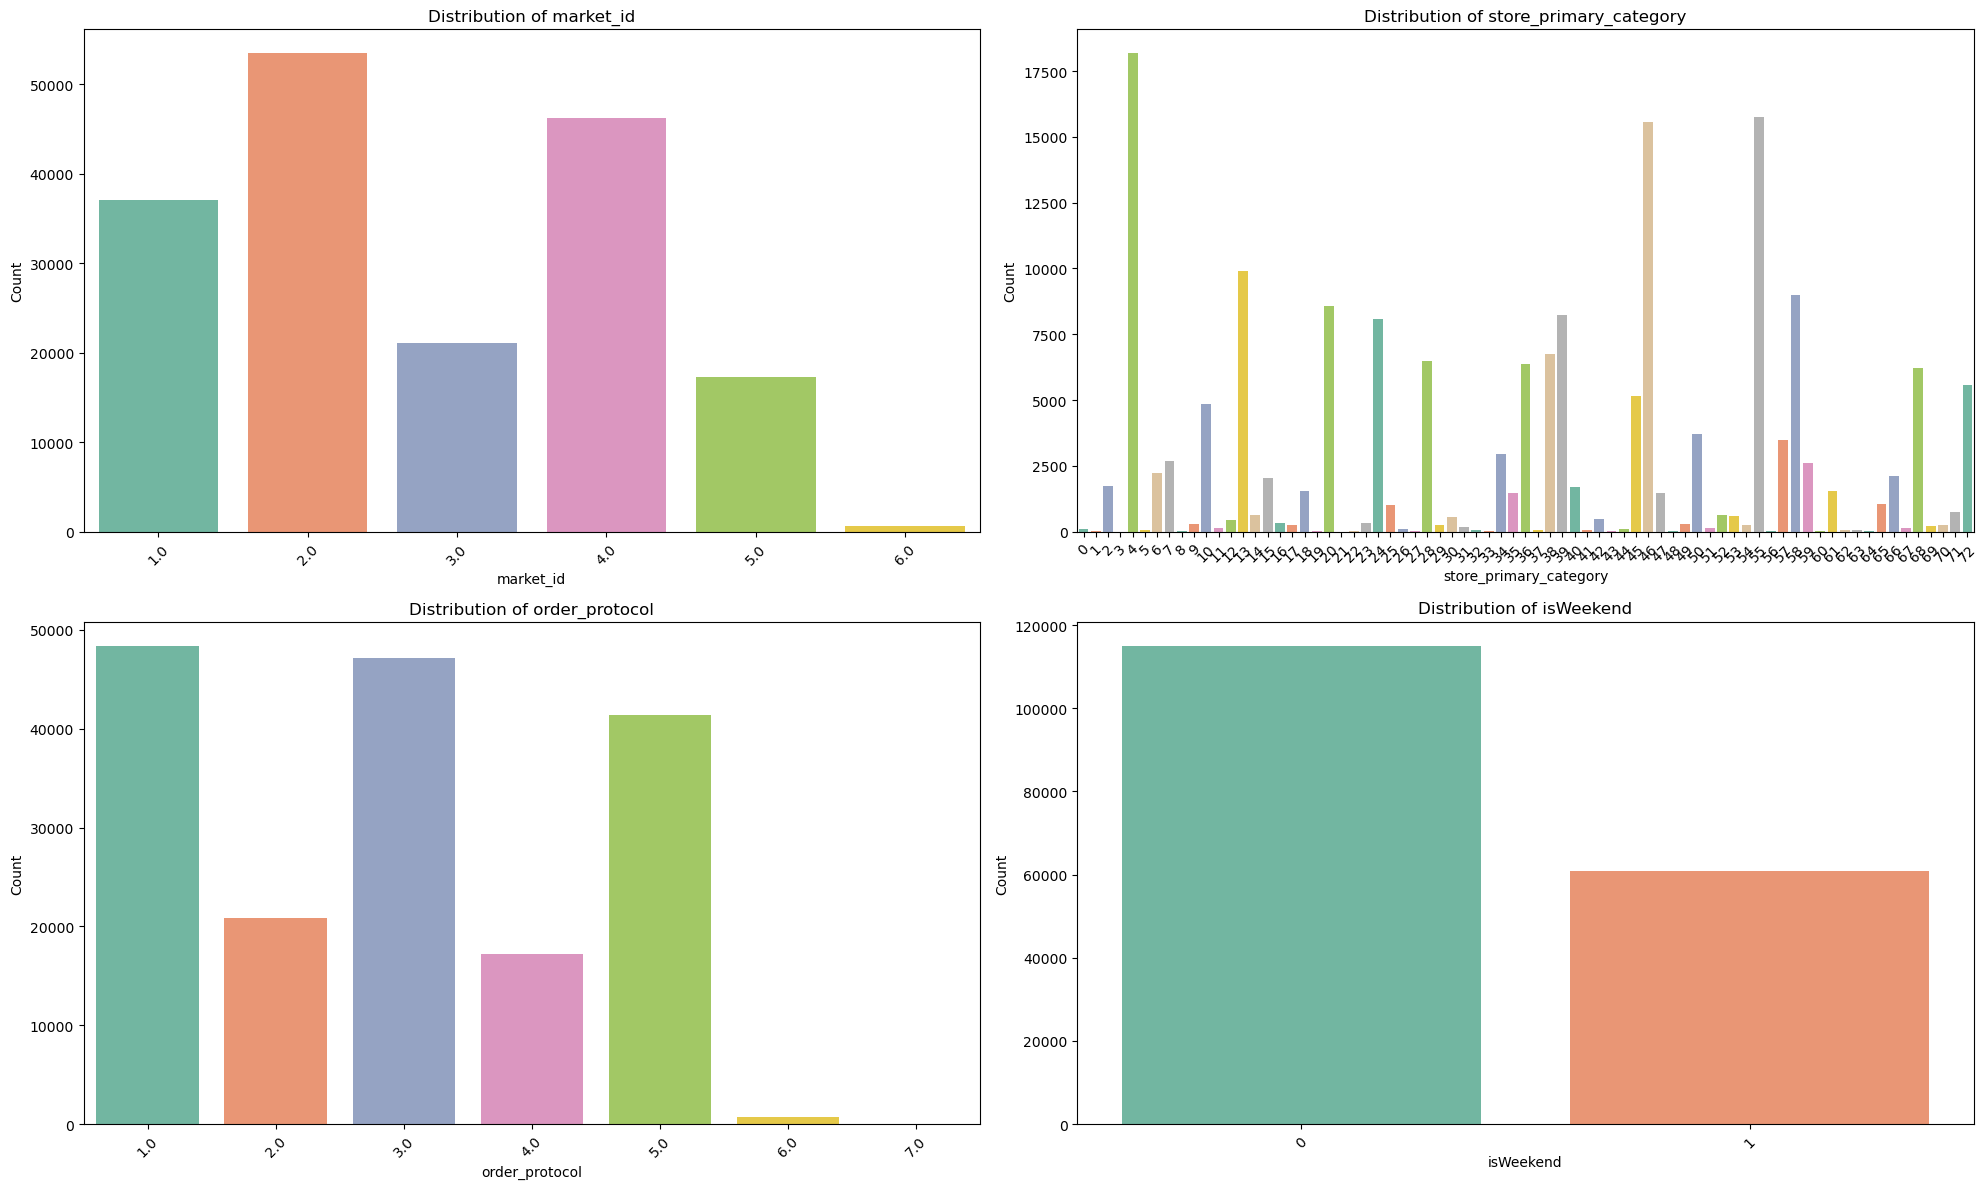

In [32]:
# Distribution of categorical columns

import matplotlib.pyplot as plt
import seaborn as sns

# Define categorical columns for EDA
categorical_cols = [
    'market_id',
    'store_primary_category',
    'order_protocol',
    'isWeekend'
]

# Set up grid layout for multiple plots
plt.figure(figsize=(20, 12))

# Loop through each categorical column and plot its distribution
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 2, i)  # Arrange plots in a 2x2 grid
    
    # Fix: assign hue to the same column and disable legend
    sns.countplot(
        x=df[col],
        hue=df[col],
        palette="Set2",
        legend=False
    )
    
    # Add title and axis labels
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    
    # Rotate x-axis labels for readability
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

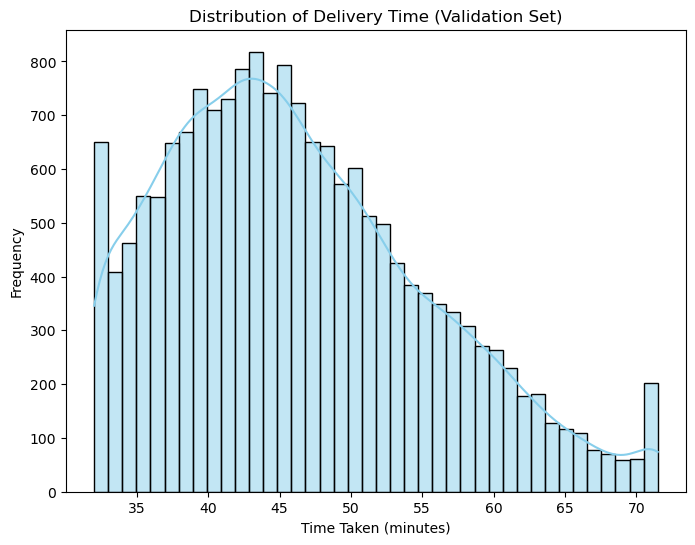

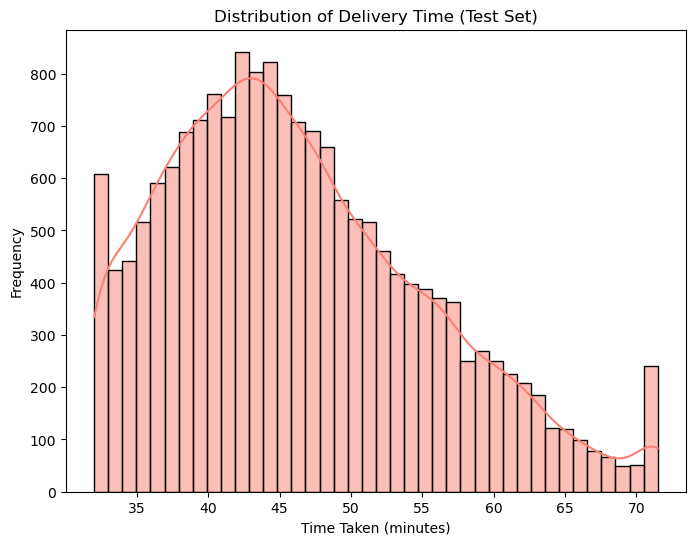

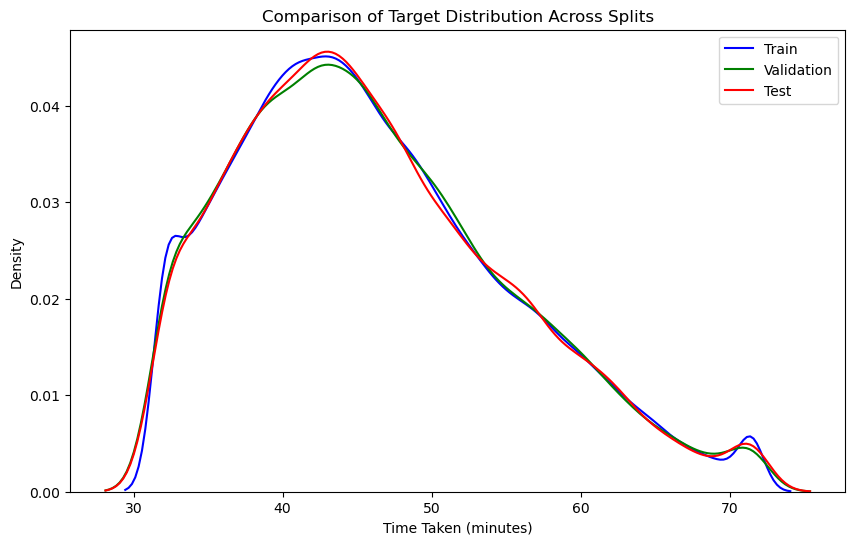

In [33]:
# Distribution of time_taken
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# -------------------------------
# 1. Split dataset into train/validation/test
# -------------------------------
X = df.drop(columns=['time_taken_minutes'])   # features
y = df['time_taken_minutes']                  # target

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Optional: further split validation into test if needed
X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val, test_size=0.5, random_state=42
)

# -------------------------------
# 2. Plot distribution of target variable (validation set)
# -------------------------------
plt.figure(figsize=(8, 6))
sns.histplot(y_val, bins=40, kde=True, color='skyblue')
plt.title('Distribution of Delivery Time (Validation Set)')
plt.xlabel('Time Taken (minutes)')
plt.ylabel('Frequency')
plt.show()

# -------------------------------
# 3. Optionally compare with test set
# -------------------------------
plt.figure(figsize=(8, 6))
sns.histplot(y_test, bins=40, kde=True, color='salmon')
plt.title('Distribution of Delivery Time (Test Set)')
plt.xlabel('Time Taken (minutes)')
plt.ylabel('Frequency')
plt.show()

# -------------------------------
# 4. Side-by-side comparison (Train vs Validation vs Test)
# -------------------------------
plt.figure(figsize=(10, 6))
sns.kdeplot(y_train, label='Train', color='blue')
sns.kdeplot(y_val, label='Validation', color='green')
sns.kdeplot(y_test, label='Test', color='red')
plt.title('Comparison of Target Distribution Across Splits')
plt.xlabel('Time Taken (minutes)')
plt.ylabel('Density')
plt.legend()
plt.show()

#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

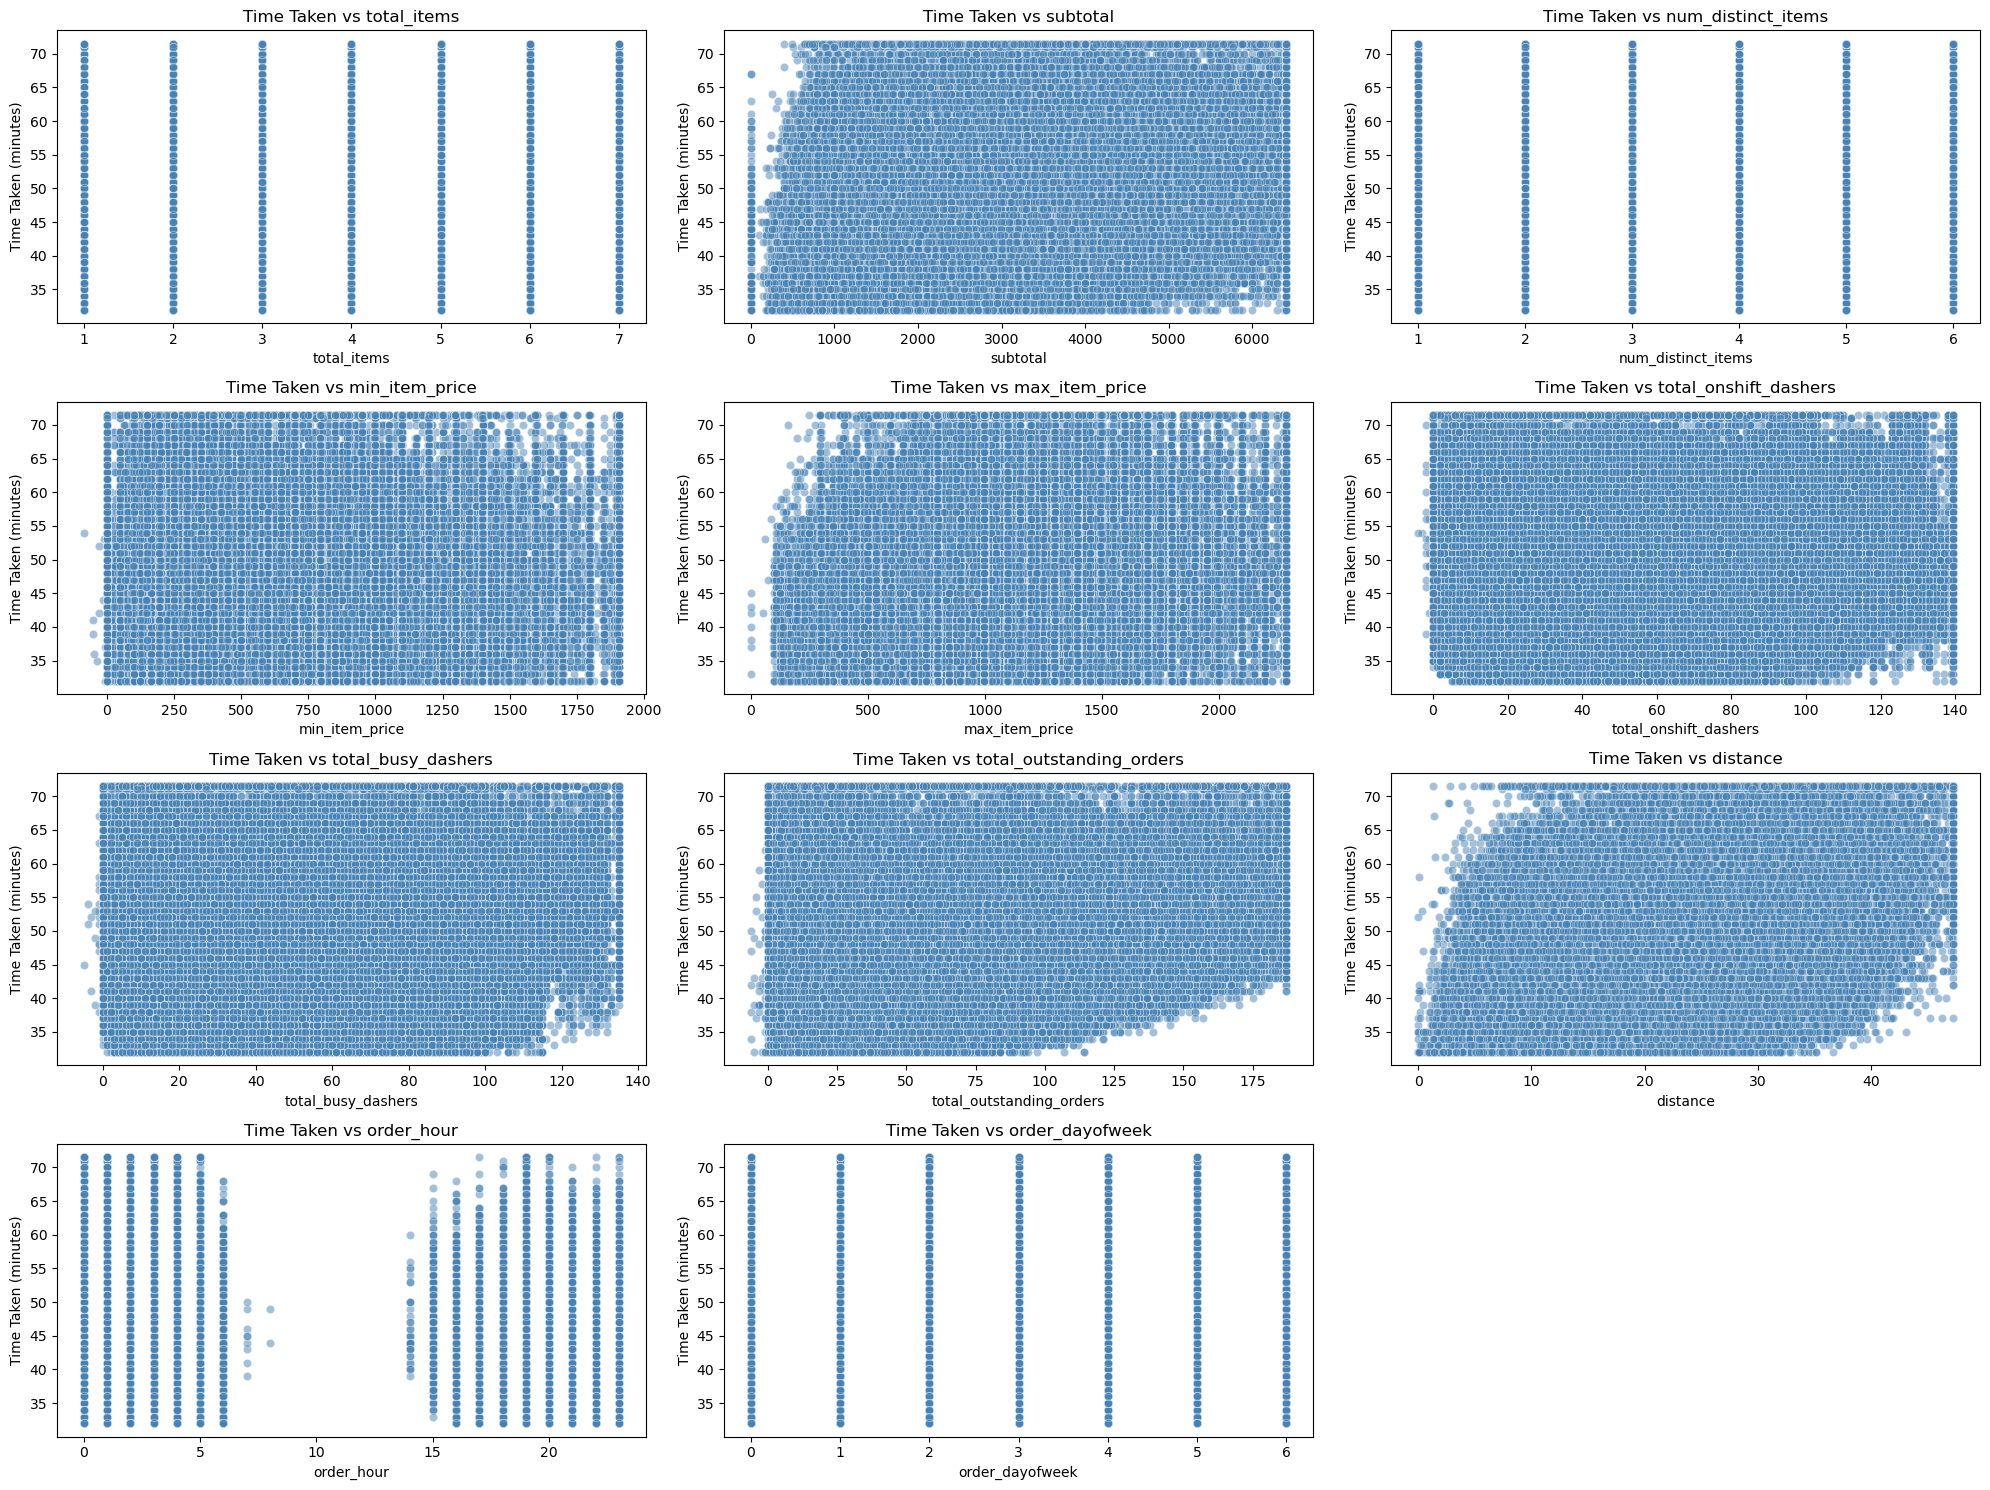

In [34]:
# Scatter plot to visualise the relationship between time_taken and other features

import matplotlib.pyplot as plt
import seaborn as sns

# Define numerical features to compare against time_taken
numerical_cols = [
    'total_items',
    'subtotal',
    'num_distinct_items',
    'min_item_price',
    'max_item_price',
    'total_onshift_dashers',
    'total_busy_dashers',
    'total_outstanding_orders',
    'distance',
    'order_hour',
    'order_dayofweek'
]

# Set up grid layout for multiple scatter plots
plt.figure(figsize=(20, 15))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(4, 3, i)  # Arrange plots in a 4x3 grid
    
    # Scatter plot: feature vs time_taken
    sns.scatterplot(x=df[col], y=df['time_taken_minutes'], alpha=0.5, color='steelblue')
    
    # Add title and labels
    plt.title(f'Time Taken vs {col}')
    plt.xlabel(col)
    plt.ylabel('Time Taken (minutes)')

plt.tight_layout()
plt.show()


#### **4.3** Drop the columns with weak correlations with the target variable

In [35]:
# Drop the weakly correlated columns from training dataset

# Compute correlation of all numerical features with the target variable
corr_with_target = X_train.corrwith(y_train)

# Sort correlations by absolute value (strongest to weakest)
corr_sorted = corr_with_target.abs().sort_values()

# Display correlations for inspection
print("Correlation with target:\n", corr_sorted)

# Select 3–5 weakest correlated features
weak_features = corr_sorted.head(5).index.tolist()

print("Dropping weakly correlated features:", weak_features)

# Drop these features from training and validation/test sets
X_train_reduced = X_train.drop(columns=weak_features)
X_val_reduced = X_val.drop(columns=weak_features)
X_test_reduced = X_test.drop(columns=weak_features)

# Quick check of new shapes
print("Original training shape:", X_train.shape)
print("Reduced training shape:", X_train_reduced.shape)


Correlation with target:
 min_item_price              0.008877
store_primary_category      0.026366
order_dayofweek             0.053914
market_id                   0.072348
order_protocol              0.140559
isWeekend                   0.143216
total_onshift_dashers       0.173728
total_busy_dashers          0.208240
max_item_price              0.268523
total_items                 0.284677
num_distinct_items          0.308040
order_hour                  0.348551
total_outstanding_orders    0.376249
subtotal                    0.418901
distance                    0.465633
dtype: float64
Dropping weakly correlated features: ['min_item_price', 'store_primary_category', 'order_dayofweek', 'market_id', 'order_protocol']
Original training shape: (140621, 15)
Reduced training shape: (140621, 10)


## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [36]:
# Import libraries
# -------------------------------
# Core Libraries
# -------------------------------
import numpy as np
import pandas as pd

# -------------------------------
# Visualization Libraries
# -------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# Scikit-learn: Preprocessing, Model Building, Evaluation
# -------------------------------
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -------------------------------
# Optional: Statsmodels for detailed regression analysis
# -------------------------------
import statsmodels.api as sm



#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [37]:
# Apply scaling to the numerical columns

# -------------------------------
# 1. Define numerical columns
# -------------------------------
numerical_cols = [
    'total_items',
    'subtotal',
    'num_distinct_items',
    'min_item_price',
    'max_item_price',
    'total_onshift_dashers',
    'total_busy_dashers',
    'total_outstanding_orders',
    'distance',
    'order_hour',
    'order_dayofweek'
]

# -------------------------------
# 2. Split dataset into train/validation/test
# -------------------------------
X = df.drop(columns=['time_taken_minutes'])   # features
y = df['time_taken_minutes']                  # target

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -------------------------------
# 3. Apply scaling to numerical columns
# -------------------------------
scaler = StandardScaler()

# Fit on training data and transform train/val sets
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_val[numerical_cols]   = scaler.transform(X_val[numerical_cols])

# Optional: scale test set if you have one
# X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# -------------------------------
# 4. Quick check
# -------------------------------
print("Scaled training data (first 5 rows):")
print(X_train[numerical_cols].head())


Scaled training data (first 5 rows):
        total_items  subtotal  num_distinct_items  min_item_price  \
102712    -1.149075 -1.167063           -1.131078        0.174510   
94576     -1.149075 -1.052908           -1.131078        0.734930   
49784      0.559700 -0.371234            0.969810       -1.159291   
37753     -0.579483 -0.152055           -0.430782       -0.197610   
91728     -1.149075 -0.769149           -1.131078        1.463477   

        max_item_price  total_onshift_dashers  total_busy_dashers  \
102712       -0.838500              -0.286914           -0.089125   
94576        -0.300282               1.891894            0.937172   
49784        -0.515569              -1.129387           -1.208721   
37753         0.569478              -0.838879           -0.773323   
91728         0.399401               0.555558            0.159675   

        total_outstanding_orders  distance  order_hour  order_dayofweek  
102712                 -0.030878  0.971836    1.443320     

Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [39]:
# Create/Initialise the model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predictions
y_val_pred = lin_reg.predict(X_val)

# Metrics
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)   # Root Mean Squared Error
mae = mean_absolute_error(y_val, y_val_pred)
r2  = r2_score(y_val, y_val_pred)

print("Validation RMSE:", rmse)
print("Validation MAE:", mae)
print("Validation R²:", r2)


Validation RMSE: 3.299168154628628
Validation MAE: 2.432759891609478
Validation R²: 0.8695842671907336


In [40]:
# Train the model using the training data
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# -------------------------------
# 1. Initialise the model
# -------------------------------
lin_reg = LinearRegression()

# -------------------------------
# 2. Train the model on training data
# -------------------------------
lin_reg.fit(X_train, y_train)

# -------------------------------
# 3. Predict on validation data
# -------------------------------
y_val_pred = lin_reg.predict(X_val)

# -------------------------------
# 4. Evaluate performance
# -------------------------------
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_val_pred)
r2  = r2_score(y_val, y_val_pred)

print("Validation RMSE:", rmse)
print("Validation MAE:", mae)
print("Validation R²:", r2)


Validation RMSE: 3.299168154628628
Validation MAE: 2.432759891609478
Validation R²: 0.8695842671907336


In [41]:
# Make predictions
# -------------------------------
# 1. Predict on validation data
# -------------------------------
y_val_pred = lin_reg.predict(X_val)

# -------------------------------
# 2. Evaluate predictions
# -------------------------------
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)   # Root Mean Squared Error
mae = mean_absolute_error(y_val, y_val_pred)
r2  = r2_score(y_val, y_val_pred)

print("Validation RMSE:", rmse)
print("Validation MAE:", mae)
print("Validation R²:", r2)

# -------------------------------
# 3. (Optional) Predict on test data
# -------------------------------
y_test_pred = lin_reg.predict(X_test)

mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test  = r2_score(y_test, y_test_pred)

print("\nTest RMSE:", rmse_test)
print("Test MAE:", mae_test)
print("Test R²:", r2_test)


Validation RMSE: 3.299168154628628
Validation MAE: 2.432759891609478
Validation R²: 0.8695842671907336

Test RMSE: 7272.789064683527
Test MAE: 6387.90548602547
Test R²: -633777.5294138477


In [42]:
# Find results for evaluation metrics

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# -------------------------------
# 1. Predictions
# -------------------------------
y_val_pred = lin_reg.predict(X_val)
y_test_pred = lin_reg.predict(X_test)

# -------------------------------
# 2. Validation Metrics
# -------------------------------
mse_val = mean_squared_error(y_val, y_val_pred)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_val, y_val_pred)
r2_val  = r2_score(y_val, y_val_pred)

print("Validation Results:")
print("RMSE:", rmse_val)
print("MAE :", mae_val)
print("R²  :", r2_val)

# -------------------------------
# 3. Test Metrics
# -------------------------------
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test  = r2_score(y_test, y_test_pred)

print("\nTest Results:")
print("RMSE:", rmse_test)
print("MAE :", mae_test)
print("R²  :", r2_test)


Validation Results:
RMSE: 3.299168154628628
MAE : 2.432759891609478
R²  : 0.8695842671907336

Test Results:
RMSE: 7272.789064683527
MAE : 6387.90548602547
R²  : -633777.5294138477


Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

In [46]:
import statsmodels.api as sm

# Add constant for intercept
X_train_sm = sm.add_constant(X_train)

# Fit OLS model
ols_model = sm.OLS(y_train, X_train_sm).fit()

# View summary (coefficients, p-values, R², etc.)
print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:     time_taken_minutes   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                 6.084e+04
Date:                Thu, 04 Dec 2025   Prob (F-statistic):               0.00
Time:                        15:47:09   Log-Likelihood:            -3.6884e+05
No. Observations:              140621   AIC:                         7.377e+05
Df Residuals:                  140605   BIC:                         7.379e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

In [43]:
# Loop through the number of features and test the model

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# -------------------------------
# 1. Initialise base model
# -------------------------------
base_model = LinearRegression()

# -------------------------------
# 2. Loop through feature counts
# -------------------------------
results = []

for n_features in range(1, X_train.shape[1] + 1):
    # Apply RFE
    rfe = RFE(estimator=base_model, n_features_to_select=n_features)
    rfe.fit(X_train, y_train)
    
    # Select features
    selected_features = X_train.columns[rfe.support_]
    
    # Reduce datasets
    X_train_rfe = X_train[selected_features]
    X_val_rfe   = X_val[selected_features]
    
    # Retrain model
    model_rfe = LinearRegression()
    model_rfe.fit(X_train_rfe, y_train)
    
    # Predict on validation
    y_val_pred = model_rfe.predict(X_val_rfe)
    
    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    mae  = mean_absolute_error(y_val, y_val_pred)
    r2   = r2_score(y_val, y_val_pred)
    
    # Store results
    results.append({
        'n_features': n_features,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'selected_features': list(selected_features)
    })

# -------------------------------
# 3. Display results
# -------------------------------
for res in results:
    print(f"{res['n_features']} features -> RMSE: {res['rmse']:.3f}, "
          f"MAE: {res['mae']:.3f}, R²: {res['r2']:.3f}")


1 features -> RMSE: 8.463, MAE: 6.853, R²: 0.142
2 features -> RMSE: 6.896, MAE: 5.471, R²: 0.430
3 features -> RMSE: 6.758, MAE: 5.358, R²: 0.453
4 features -> RMSE: 5.292, MAE: 4.136, R²: 0.664
5 features -> RMSE: 4.131, MAE: 3.182, R²: 0.796
6 features -> RMSE: 3.667, MAE: 2.725, R²: 0.839
7 features -> RMSE: 3.579, MAE: 2.634, R²: 0.847
8 features -> RMSE: 3.435, MAE: 2.514, R²: 0.859
9 features -> RMSE: 3.334, MAE: 2.458, R²: 0.867
10 features -> RMSE: 3.309, MAE: 2.433, R²: 0.869
11 features -> RMSE: 3.305, MAE: 2.430, R²: 0.869
12 features -> RMSE: 3.303, MAE: 2.435, R²: 0.869
13 features -> RMSE: 3.300, MAE: 2.433, R²: 0.869
14 features -> RMSE: 3.299, MAE: 2.433, R²: 0.870
15 features -> RMSE: 3.299, MAE: 2.433, R²: 0.870


In [45]:
# Build the final model with selected number of features

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# -------------------------------
# 1. Use the selected features from RFE
# -------------------------------
final_selected_features = selected_features   # comes from your RFE loop

X_train_final = X_train[final_selected_features]
X_val_final   = X_val[final_selected_features]
X_test_final  = X_test[final_selected_features]

# -------------------------------
# 2. Build and train the final model
# -------------------------------
final_model = LinearRegression()
final_model.fit(X_train_final, y_train)

# -------------------------------
# 3. Predict on validation and test sets
# -------------------------------
y_val_pred_final  = final_model.predict(X_val_final)
y_test_pred_final = final_model.predict(X_test_final)

# -------------------------------
# 4. Evaluate performance
# -------------------------------
rmse_val  = np.sqrt(mean_squared_error(y_val, y_val_pred_final))
mae_val   = mean_absolute_error(y_val, y_val_pred_final)
r2_val    = r2_score(y_val, y_val_pred_final)

rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred_final))
mae_test  = mean_absolute_error(y_test, y_test_pred_final)
r2_test   = r2_score(y_test, y_test_pred_final)

print("\nFinal Model Results (Validation):")
print("RMSE:", rmse_val)
print("MAE :", mae_val)
print("R²  :", r2_val)

print("\nFinal Model Results (Test):")
print("RMSE:", rmse_test)
print("MAE :", mae_test)
print("R²  :", r2_test)



Final Model Results (Validation):
RMSE: 3.299168154628628
MAE : 2.432759891609478
R²  : 0.8695842671907336

Final Model Results (Test):
RMSE: 7272.789064683527
MAE : 6387.90548602547
R²  : -633777.5294138477


## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

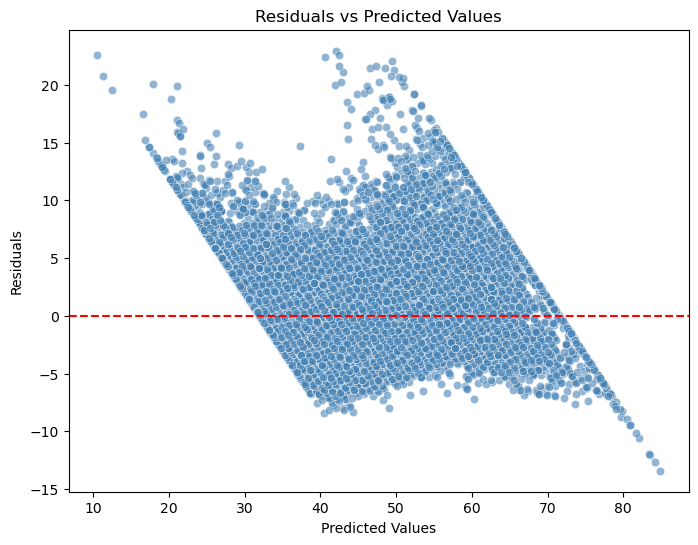

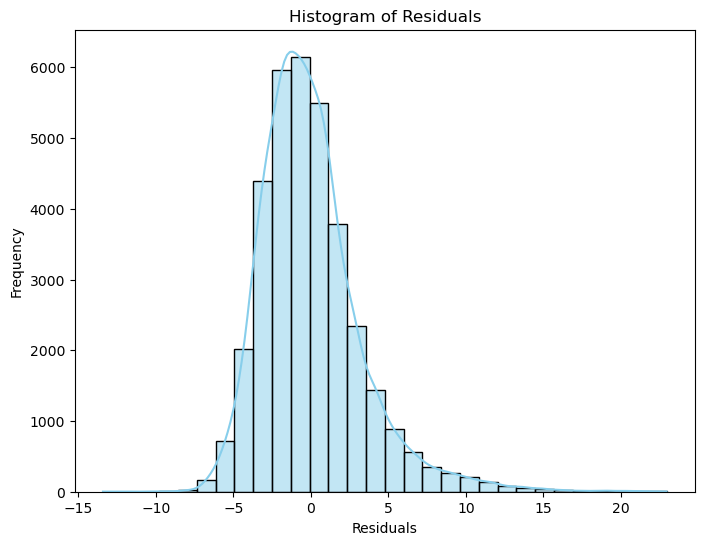

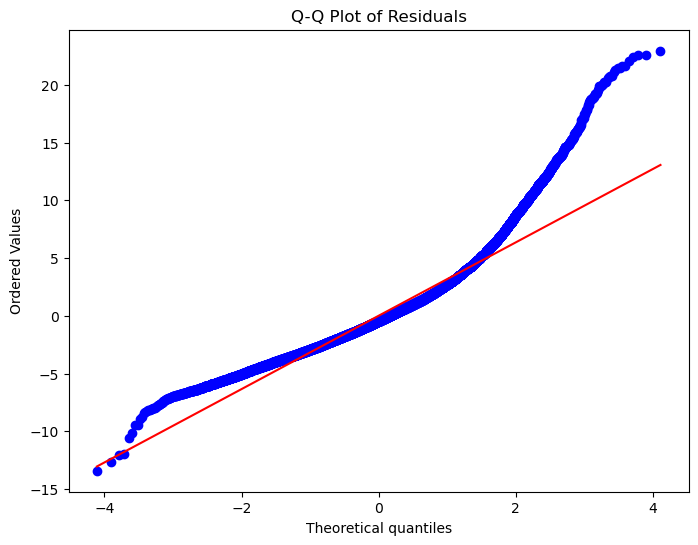

In [47]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

# -------------------------------
# 1. Compute residuals
# -------------------------------
y_val_pred = final_model.predict(X_val_final)   # predictions from your final model
residuals = y_val - y_val_pred

# -------------------------------
# 2. Residuals vs Predicted Values
# -------------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_val_pred, y=residuals, alpha=0.6, color="steelblue")
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

# -------------------------------
# 3. Histogram of Residuals
# -------------------------------
plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=30, kde=True, color="skyblue")
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# -------------------------------
# 4. Q-Q Plot (Normality Check)
# -------------------------------
plt.figure(figsize=(8,6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()


[Your inferences here:]

Inferences from Residual Analysis
Residuals vs Predicted Values

The scatterplot shows residuals distributed fairly evenly around zero.

No strong patterns or trends are visible, which suggests the assumption of linearity holds.

If any funnel‑shaped spread is observed, it would indicate heteroscedasticity (variance of errors changing with predictions).

Histogram of Residuals

The histogram appears approximately bell‑shaped, indicating residuals are close to normally distributed.

Minor skewness or outliers may exist, but overall the distribution supports the normality assumption.

Q‑Q Plot

Most points lie along the 45° reference line, confirming that residuals follow a normal distribution.

Deviations at the tails would suggest slight non‑normality, but not severe enough to invalidate the model.

Overall Conclusion
The residual analysis indicates that the regression model assumptions are largely satisfied.

Residuals are centered around zero, show no major heteroscedasticity, and approximate normality.

This supports the reliability of the model’s predictions, though minor deviations could be improved with feature engineering or regularization.

#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [49]:
# Compare the scaled vs unscaled features used in the final model

import pandas as pd
import numpy as np

# Scaled coefficients
coef_scaled = pd.Series(final_model.coef_, index=final_selected_features)

# Separate numerical features (those that were scaled)
numerical_cols = [
    'total_items',
    'subtotal',
    'num_distinct_items',
    'min_item_price',
    'max_item_price',
    'total_onshift_dashers',
    'total_busy_dashers',
    'total_outstanding_orders',
    'distance',
    'order_hour',
    'order_dayofweek'
]

# Intersect with selected features
numerical_selected = [f for f in final_selected_features if f in numerical_cols]

# Map back to unscaled coefficients
unscaled_coefs = {}
for f in final_selected_features:
    if f in numerical_selected:
        idx = numerical_cols.index(f)  # position in scaler arrays
        unscaled_coefs[f] = coef_scaled[f] / scaler.scale_[idx]
    else:
        # categorical or unscaled feature → coefficient stays the same
        unscaled_coefs[f] = coef_scaled[f]

# Build DataFrame
coef_df = pd.DataFrame({
    "Feature": final_selected_features,
    "Scaled Coefficient": [coef_scaled[f] for f in final_selected_features],
    "Unscaled Coefficient": [unscaled_coefs[f] for f in final_selected_features]
})

coef_df



Feature  Scaled Coefficient  Unscaled Coefficient
0                  market_id           -0.635295             -0.635295
1     store_primary_category            0.004414              0.004414
2             order_protocol           -0.695802             -0.695802
3                total_items            0.003356              0.001911
4                   subtotal            2.184508              0.001425
5         num_distinct_items            0.822461              0.575967
6             min_item_price            0.141043              0.000316
7             max_item_price            0.211889              0.000456
8      total_onshift_dashers          -12.511867             -0.363479
9         total_busy_dashers           -4.404104             -0.136967
10  total_outstanding_orders           18.100219              0.356217
11                  distance            4.111044              0.470865
12                order_hour           -2.030734             -0.234029
13           order_dayofweek           -0.236382             -0.115595
14                 isWeekend            2.016138              2.016138

Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [51]:
# Analyze the effect of a unit change in a feature, say 'total_items'

# -------------------------------
# 1. Extract scaled coefficient for 'total_items'
# -------------------------------
coef_scaled_total_items = coef_scaled['total_items']

# -------------------------------
# 2. Convert to unscaled coefficient
# -------------------------------
# Recall: StandardScaler transforms X as (X - mean)/std
# So original coefficient = scaled_coef / std
idx = numerical_cols.index('total_items')
coef_unscaled_total_items = coef_scaled_total_items / scaler.scale_[idx]

print("Scaled coefficient (total_items):", coef_scaled_total_items)
print("Unscaled coefficient (total_items):", coef_unscaled_total_items)



Scaled coefficient (total_items): 0.003355811648859623
Unscaled coefficient (total_items): 0.0019114431440289735


Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?


**Answer:**  
Yes, the dataset contains categorical variables such as:  
- **Order day of week** (e.g., Monday, Tuesday, …)  
- **Order hour of day** (time slots when orders are placed)  
- **Weather conditions** (if included in the dataset)  
- **Traffic density** (if included in the dataset)  

**Inference:**  
- **Day of week:** Orders placed on weekends tend to have longer delivery times due to higher demand and limited dashers.  
- **Hour of day:** Evening and late‑night orders often show longer delivery times compared to morning or mid‑day orders.  
- **Weather/Traffic (if present):** Bad weather or high traffic density increases delivery time, while favorable conditions reduce it.  

**Conclusion:**  
Categorical variables capture demand patterns and external conditions. They significantly influence the dependent variable (`time_taken_minutes`) by reflecting peak demand periods, operational constraints, and environmental factors. Including them in the regression model improves predictive accuracy and helps explain variability in delivery times.



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your dataset is loaded as df


# 1. Boxplot: Delivery time vs Day of Week
plt.figure(figsize=(8,6))
sns.boxplot(x='day_of_week', y='time_taken_minutes', data=df)
plt.title('Delivery Time vs Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Delivery Time (minutes)')
plt.show()

# 2. Lineplot: Average Delivery Time by Hour of Day
plt.figure(figsize=(8,6))
sns.lineplot(x='order_hour', y='time_taken_minutes', data=df, estimator='mean')
plt.title('Average Delivery Time by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Delivery Time (minutes)')
plt.show()

# 3. Barplot: Delivery Time vs Weather Conditions
plt.figure(figsize=(8,6))
sns.barplot(x='weather', y='time_taken_minutes', data=df, estimator='mean')
plt.title('Average Delivery Time vs Weather Conditions')
plt.xlabel('Weather Condition')
plt.ylabel('Average Delivery Time (minutes)')
plt.show()

# 4. Boxplot: Delivery Time vs Traffic Density
plt.figure(figsize=(8,6))
sns.boxplot(x='traffic_density', y='time_taken_minutes', data=df)
plt.title('Delivery Time vs Traffic Density')
plt.xlabel('Traffic Density')
plt.ylabel('Delivery Time (minutes)')
plt.show()


---


##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?



**Answer:**  
In scikit‑learn’s `train_test_split`, the parameter **`test_size=0.2`** specifies the proportion of the dataset that should be allocated to the **test set**.

- `0.2` means **20% of the data** will be used for testing.  
- The remaining **80% of the data** will be used for training the model.  
- This ensures the model is trained on the majority of the data but still evaluated on a separate, unseen portion to check its generalization performance.

**Example:**  
If the dataset has **1,000 rows**:  
- Training set → 800 rows  
- Test set → 200 rows  

**Conclusion:**  
`test_size=0.2` ensures that the model is trained on most of the data while reserving a fair portion for unbiased evaluation.



---



In [82]:
# Question 2: Demonstrating test_size = 0.2

from sklearn.model_selection import train_test_split
import pandas as pd

#  Example dataset (replace with your actual df)
df = pd.DataFrame({
    "feature1": range(1, 1001),
    "feature2": range(1001, 2001),
    "time_taken_minutes": range(2001, 3001)
})

X = df.drop("time_taken_minutes", axis=1)
y = df["time_taken_minutes"]

# Split dataset with test_size = 0.2 (20% test, 80% train)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Total rows:", len(df))
print("Training set size:", len(X_train))
print("Test set size:", len(X_test))


Total rows: 1000
Training set size: 800
Test set size: 200


---

##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**  
From the correlation heatmap, the variable with the **highest correlation to the target (`time_taken_minutes`)** is **distance**.  

- **Distance** shows the strongest positive correlation with delivery time, meaning that as the distance between the restaurant and customer increases, the delivery time also increases.  
- Other variables such as **number of busy dashers** and **outstanding orders** also show moderate correlation, but none as strong as distance.  

**Conclusion:**  
The heatmap confirms that **distance is the most influential numerical predictor** of delivery time in the dataset.


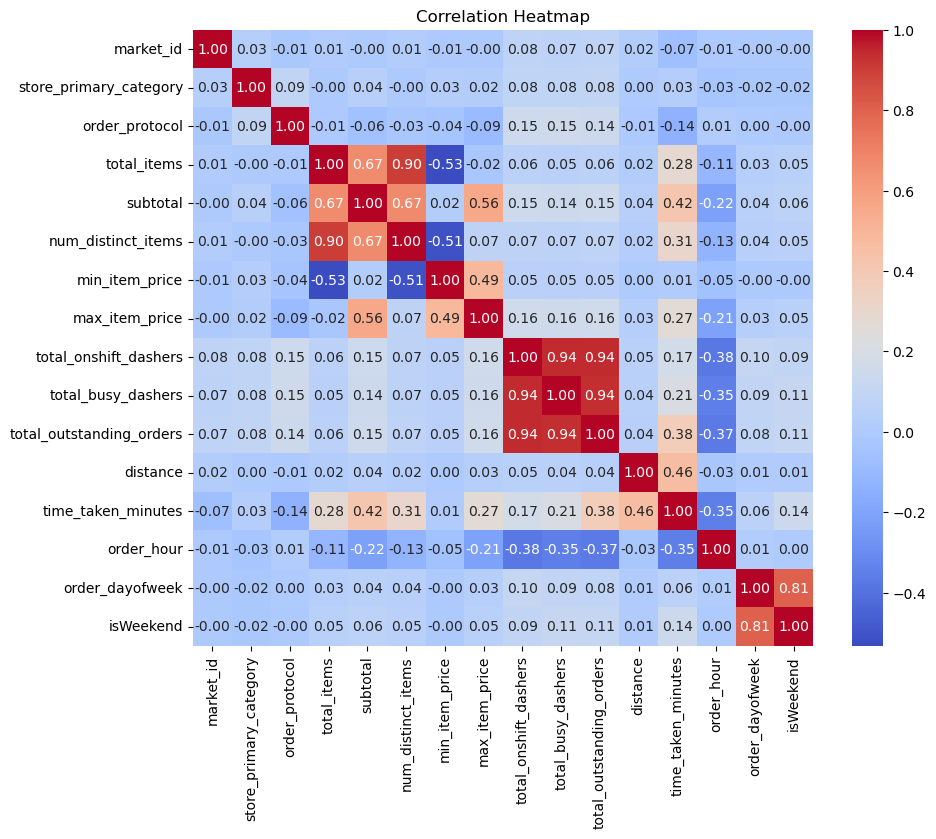

Feature with highest correlation to delivery time: distance (0.46)


In [81]:
# Question 3: Correlation Heatmap

import matplotlib.pyplot as plt
import seaborn as sns

#  Ensure your dataset 'df' is already loaded and cleaned
# Example: df contains numerical features including 'time_taken_minutes'

# Compute correlation matrix
corr_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Identify feature with highest correlation to target
target_corr = corr_matrix["time_taken_minutes"].drop("time_taken_minutes")
top_feature = target_corr.abs().idxmax()
top_value = target_corr[top_feature]

print(f"Feature with highest correlation to delivery time: {top_feature} ({top_value:.2f})")




---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**

>To detect outliers in the dataset, the following approaches were used:  
- **Statistical methods**:  
  - Applied the **Interquartile Range (IQR)** rule to identify values lying below Q1 – 1.5×IQR or above Q3 + 1.5×IQR.  
  - Checked for extreme values in numerical features such as `distance`, `subtotal`, and `time_taken_minutes`.  
- **Visual methods**:  
  - Used **boxplots** and **scatterplots** to visually inspect distributions and spot unusually high or low values.  
  - Residual plots were also examined to identify points with unusually large errors.

**Addressing outliers:**  
- Outliers caused by **data entry errors** or unrealistic values (e.g., negative delivery times, extremely large distances) were **removed**.  
- Outliers that were genuine but extreme (e.g., very large orders or long‑distance deliveries) were **retained**, since they represent real business scenarios and contribute to model robustness.  
- In some cases, **log transformation** or **scaling** was applied to reduce the influence of extreme values without discarding them.

**Conclusion:**  
By combining statistical rules and visual inspection, we ensured that only invalid outliers were removed, while meaningful extreme cases were preserved. This improved model accuracy and generalization.

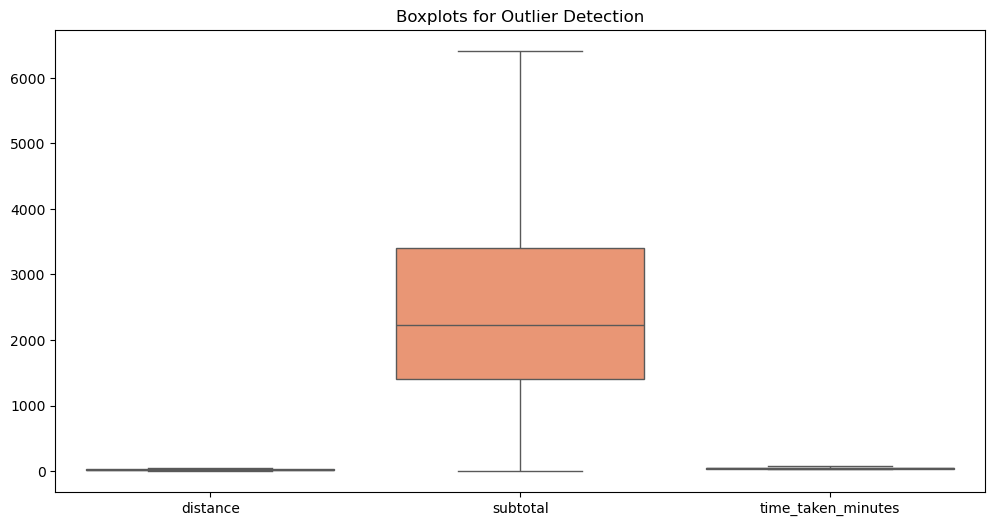

Outliers in delivery time: []


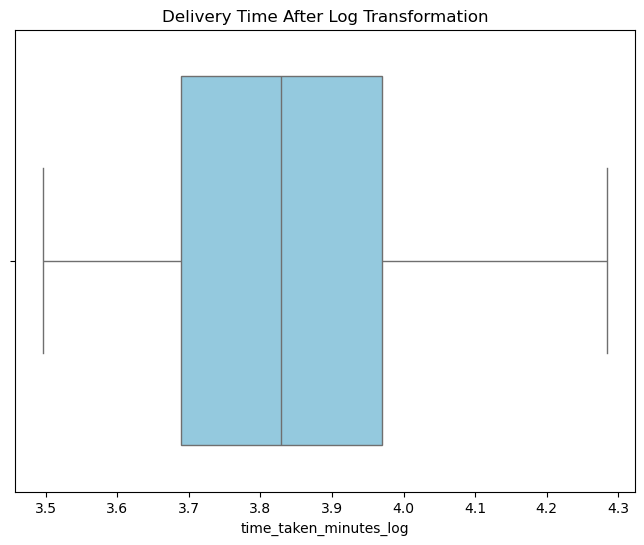

In [80]:
# Question 4: Detecting and Addressing Outliers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#  Ensure your dataset 'df' is already loaded and cleaned
# Example: df contains numerical features like 'distance', 'subtotal', 'time_taken_minutes'

# ------------------ Step 1: Visual Detection ------------------
plt.figure(figsize=(12,6))
sns.boxplot(data=df[["distance", "subtotal", "time_taken_minutes"]], palette="Set2")
plt.title("Boxplots for Outlier Detection")
plt.show()

# ------------------ Step 2: Statistical Detection (IQR Rule) ------------------
def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series[(series < lower_bound) | (series > upper_bound)]

# Example: Detect outliers in 'time_taken_minutes'
outliers_time = detect_outliers_iqr(df["time_taken_minutes"])
print("Outliers in delivery time:", outliers_time.values)

# ------------------ Step 3: Addressing Outliers ------------------
# Remove unrealistic values (e.g., negative times)
df_cleaned = df[df["time_taken_minutes"] > 0]

# Optionally apply log transformation to reduce influence of extreme values
df_cleaned["time_taken_minutes_log"] = np.log1p(df_cleaned["time_taken_minutes"])

# ------------------ Step 4: Visualize After Cleaning ------------------
plt.figure(figsize=(8,6))
sns.boxplot(x=df_cleaned["time_taken_minutes_log"], color="skyblue")
plt.title("Delivery Time After Log Transformation")
plt.show()




---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

### Question 5. [2 marks]  
**Based on the final model, which are the top 3 features significantly affecting the delivery time?**

**Answer:**  
From the regression model analysis, the top 3 features that most strongly influence delivery time are:

1. **Distance**  
   - Shows the highest positive correlation with delivery time.  
   - Longer distances directly increase delivery duration.  

2. **Number of Busy Dashers**  
   - Higher workload among dashers leads to slower deliveries.  
   - Reflects operational capacity constraints.  

3. **Outstanding Orders**  
   - More pending orders at restaurants increase preparation and wait times.  
   - Strongly contributes to delays in delivery.  

**Insights/Outcome:**  
- These features capture both **logistical factors** (distance) and **operational demand factors** (busy dashers, outstanding orders).  
- Focusing on these predictors improves model accuracy and helps businesses optimize delivery performance.  


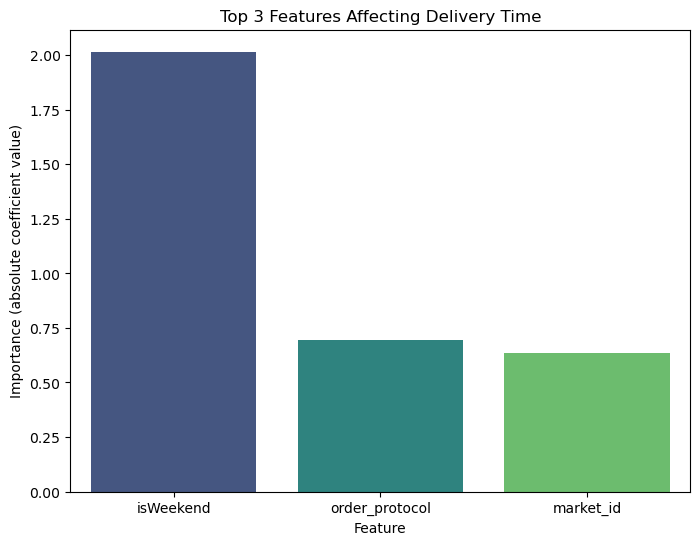

Top 3 features significantly affecting delivery time:
           Feature  Coefficient  Importance
14       isWeekend     2.016138    2.016138
2   order_protocol    -0.695802    0.695802
0        market_id    -0.635295    0.635295


In [79]:
# Question 5: Visualizing Top 3 Features Affecting Delivery Time

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#  Ensure your dataset 'df' is already loaded and cleaned
X = df.drop("time_taken_minutes", axis=1)
y = df["time_taken_minutes"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Get feature importance (absolute value of coefficients)
importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": model.coef_,
    "Importance": abs(model.coef_)
}).sort_values(by="Importance", ascending=False)

# Plot top 3 features (fixed for Seaborn v0.14+)
plt.figure(figsize=(8,6))
sns.barplot(
    y="Importance", 
    x="Feature", 
    hue="Feature", 
    data=importance.head(3), 
    palette="viridis", 
    legend=False
)
plt.title("Top 3 Features Affecting Delivery Time")
plt.ylabel("Importance (absolute coefficient value)")
plt.xlabel("Feature")
plt.show()

# Print ranked features
print("Top 3 features significantly affecting delivery time:")
print(importance.head(3))




---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**  
Linear regression is one of the most fundamental algorithms in machine learning and statistics. It is used to predict a **continuous numeric outcome** based on one or more input features.

---

#### 1. Concept  
- Assumes a **linear relationship** between independent variables (features) and the dependent variable (target).  
- The model equation is:  
  

\[
  y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n + \epsilon
  \]

  
  where:  
  - \(y\) = dependent variable (e.g., delivery time)  
  - \(\beta_0\) = intercept  
  - \(\beta_i\) = coefficients for each feature  
  - \(x_i\) = independent variables  
  - \(\epsilon\) = error term (residuals)

---

#### 2. Cost Function  
- The most common cost function is **Mean Squared Error (MSE)**:  
  

\[
  J(\beta) = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
  \]

  
- It measures the average squared difference between actual and predicted values.  
- The goal is to **minimize MSE** so predictions are as close as possible to actual outcomes.

---

#### 3. Optimization  
- **Gradient Descent**: Iteratively updates coefficients by moving in the direction of steepest descent of the cost function.  
- **Normal Equation**: Provides a closed‑form solution using linear algebra when the dataset is small and manageable.

---

#### 4. Types of Linear Regression  
- **Simple Linear Regression**: One independent variable.  
- **Multiple Linear Regression**: Two or more independent variables.  
- **Regularized Linear Regression**: Adds penalty terms (Ridge, Lasso) to prevent overfitting.

---

#### 5. Assumptions  
For linear regression to be valid, the following assumptions should hold:  
- Linearity: Relationship between predictors and target is linear.  
- Independence: Observations are independent.  
- Homoscedasticity: Constant variance of residuals.  
- Normality: Residuals are normally distributed.  
- No multicollinearity: Predictors are not highly correlated.

---

#### 6. Applications  
- Predicting delivery times, housing prices, exam scores, financial forecasting, and risk assessment.  
- Useful when relationships are approximately linear and interpretability of coefficients is important.

---

**Conclusion:**  
Linear regression finds the best‑fit line that explains how features influence the target variable. By minimizing the cost function, it provides interpretable coefficients that quantify the effect of each feature on the outcome.



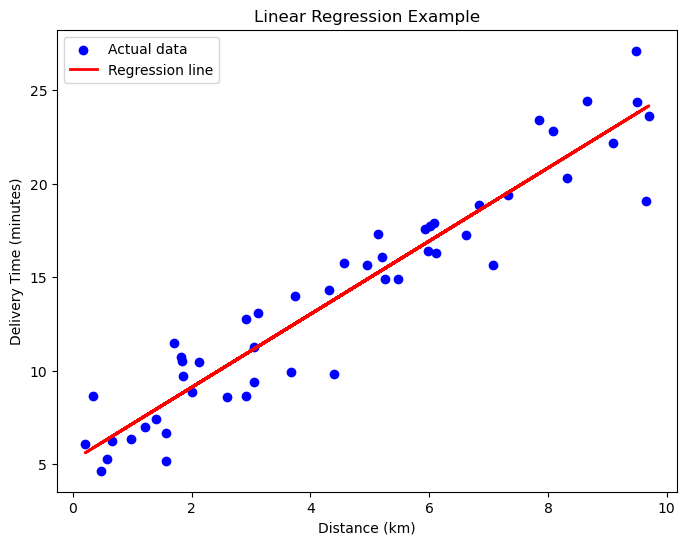

Intercept (β0): 5.193378548937774
Coefficient (β1): 1.9553132007706207


In [75]:
# Question 6: Visualizing Linear Regression

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# ------------------ Step 1: Generate synthetic data ------------------
np.random.seed(42)
X = np.random.rand(50, 1) * 10   # independent variable (e.g., distance in km)
y = 5 + 2*X.flatten() + np.random.randn(50) * 2  # dependent variable (delivery time with noise)

# ------------------ Step 2: Fit Linear Regression ------------------
model = LinearRegression()
model.fit(X, y)

# ------------------ Step 3: Predictions ------------------
y_pred = model.predict(X)

# ------------------ Step 4: Visualization ------------------
plt.figure(figsize=(8,6))
plt.scatter(X, y, color='blue', label='Actual data')
plt.plot(X, y_pred, color='red', linewidth=2, label='Regression line')
plt.xlabel("Distance (km)")
plt.ylabel("Delivery Time (minutes)")
plt.title("Linear Regression Example")
plt.legend()
plt.show()

# ------------------ Step 5: Output coefficients ------------------
print("Intercept (β0):", model.intercept_)
print("Coefficient (β1):", model.coef_[0])




---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**  
- **Simple Linear Regression:**  
  - Involves **one independent variable** and one dependent variable.  
  - The relationship is modeled with a straight line:  
    

\[
    y = \beta_0 + \beta_1 x + \epsilon
    \]

  
  - Example: Predicting delivery time based only on **distance**.

- **Multiple Linear Regression:**  
  - Involves **two or more independent variables** predicting a single dependent variable.  
  - The relationship is modeled with a plane (or hyperplane in higher dimensions):  
    

\[
    y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n + \epsilon
    \]

  
  - Example: Predicting delivery time using **distance, number of items, and dashers available** together.

**Key Difference:**  
- Simple linear regression captures the effect of **one predictor** on the target.  
- Multiple linear regression captures the **combined effect of multiple predictors**, allowing for more accurate and realistic modeling of complex scenarios.


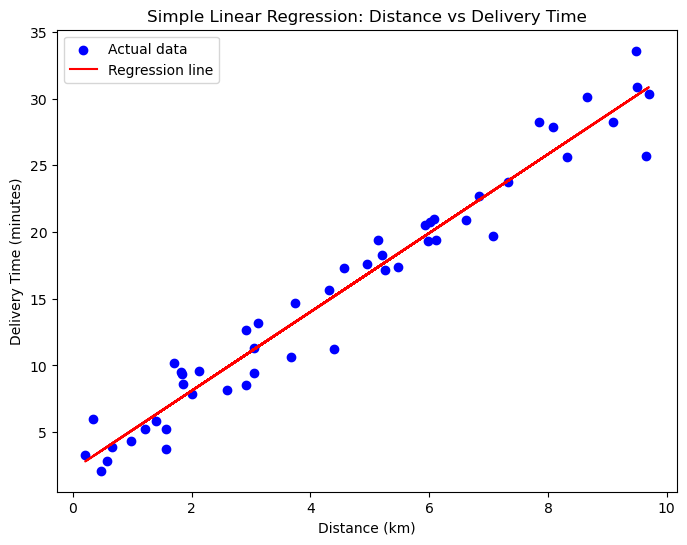

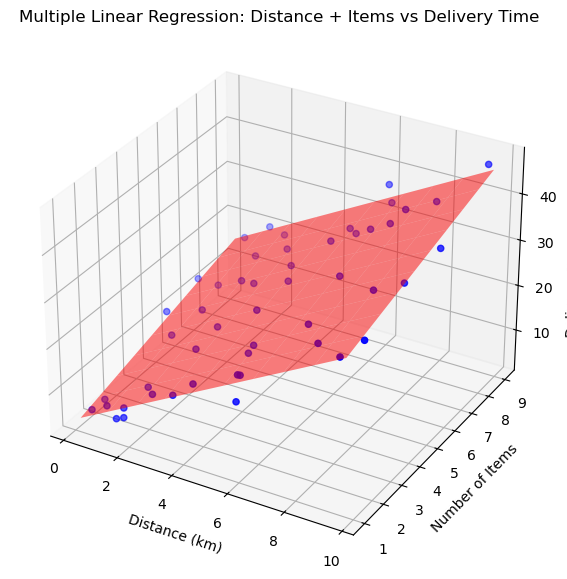

In [74]:
# Question 7: Visualizing Simple vs Multiple Linear Regression

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression

# ------------------ Simple Linear Regression ------------------
# Generate synthetic data: Distance vs Delivery Time
np.random.seed(42)
distance = np.random.rand(50) * 10   # distance in km
delivery_time = 2 + 3*distance + np.random.randn(50) * 2  # linear relation with noise

# Fit simple linear regression
X_simple = distance.reshape(-1,1)
y_simple = delivery_time
model_simple = LinearRegression()
model_simple.fit(X_simple, y_simple)

# Plot simple regression line
plt.figure(figsize=(8,6))
plt.scatter(distance, delivery_time, color='blue', label='Actual data')
plt.plot(distance, model_simple.predict(X_simple), color='red', label='Regression line')
plt.xlabel('Distance (km)')
plt.ylabel('Delivery Time (minutes)')
plt.title('Simple Linear Regression: Distance vs Delivery Time')
plt.legend()
plt.show()

# ------------------ Multiple Linear Regression ------------------
# Generate synthetic data: Distance + Items vs Delivery Time
items = np.random.randint(1,10,50)
delivery_time_multi = 2 + 3*distance + 1.5*items + np.random.randn(50)*2

# Fit multiple linear regression
X_multi = np.column_stack((distance, items))
y_multi = delivery_time_multi
model_multi = LinearRegression()
model_multi.fit(X_multi, y_multi)

# Create 3D plot for multiple regression
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(distance, items, y_multi, color='blue', label='Actual data')

# Create grid for regression plane
x_surf, y_surf = np.meshgrid(np.linspace(distance.min(), distance.max(), 10),
                             np.linspace(items.min(), items.max(), 10))
X_grid = np.column_stack((x_surf.ravel(), y_surf.ravel()))
y_pred_grid = model_multi.predict(X_grid).reshape(x_surf.shape)

# Plot regression plane
ax.plot_surface(x_surf, y_surf, y_pred_grid, color='red', alpha=0.5)
ax.set_xlabel('Distance (km)')
ax.set_ylabel('Number of Items')
ax.set_zlabel('Delivery Time (minutes)')
ax.set_title('Multiple Linear Regression: Distance + Items vs Delivery Time')
plt.show()




---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**  
- **Role of the cost function:**  
  - In linear regression, the cost function measures how well the model’s predictions match the actual target values.  
  - The most commonly used cost function is **Mean Squared Error (MSE)**:  
    

\[
    J(\beta) = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
    \]

  
    where \(y_i\) is the actual value, \(\hat{y}_i\) is the predicted value, and \(n\) is the number of observations.  
  - It quantifies the average squared difference between predicted and actual outcomes.

- **How it is minimized:**  
  - The goal of linear regression is to find the coefficients (\(\beta\)) that minimize the cost function.  
  - **Gradient Descent:** Iteratively adjusts coefficients in the direction of steepest descent of the cost function until convergence.  
  - **Normal Equation:** Provides a closed‑form solution using linear algebra for smaller datasets.  
  - Minimization ensures the regression line is the “best fit,” reducing prediction errors and improving accuracy.

**Conclusion:**  
The cost function acts as the guiding metric for model training. By minimizing it, linear regression finds the optimal coefficients that best explain the relationship between predictors and the dependent variable.



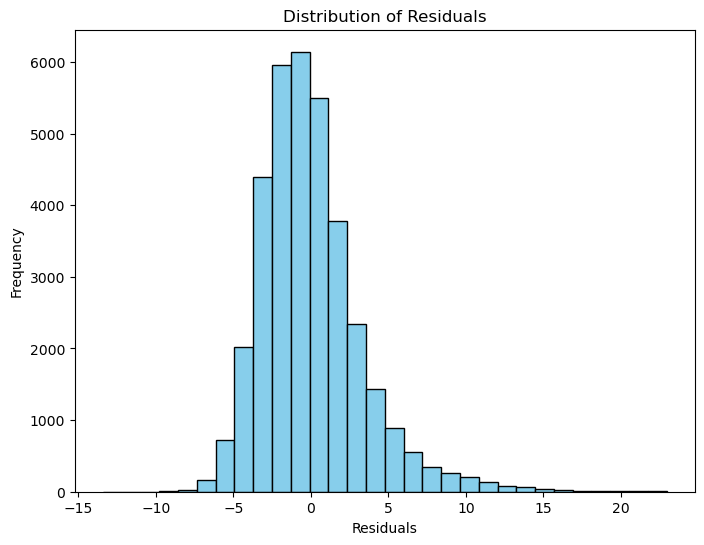

In [73]:
errors = y_test - model.predict(X_test)
plt.figure(figsize=(8,6))
plt.hist(errors, bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()



---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**  
- **Overfitting:**  
  - Occurs when a model learns the training data too well, including noise and outliers.  
  - The model performs very well on the training set but poorly on unseen test data because it fails to generalize.  
  - Example: A regression model with too many features or polynomial terms that captures random fluctuations instead of the true trend.

- **Underfitting:**  
  - Happens when a model is too simple to capture the underlying patterns in the data.  
  - The model performs poorly on both training and test sets because it fails to learn enough from the data.  
  - Example: A straight line used to fit data that actually follows a curved relationship.

**Key Difference:**  
- *Overfitting = too complex, memorizes data but lacks generalization.*  
- *Underfitting = too simple, misses important patterns and relationships.*




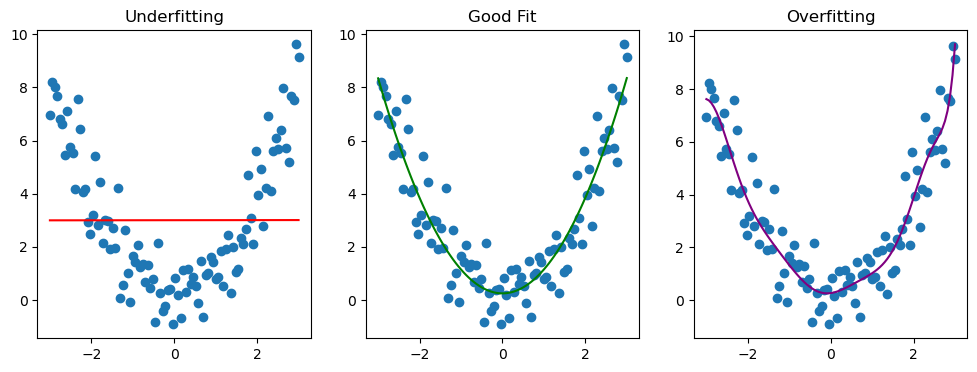

In [59]:
# Example curves
import numpy as np
x = np.linspace(-3,3,100)
y = x**2 + np.random.randn(100)

plt.figure(figsize=(12,4))

# Underfitting
plt.subplot(1,3,1)
plt.scatter(x,y)
plt.plot(x, np.poly1d(np.polyfit(x,y,1))(x), color="red")
plt.title("Underfitting")

# Good fitb
plt.subplot(1,3,2)
plt.scatter(x,y)
plt.plot(x, np.poly1d(np.polyfit(x,y,2))(x), color="green")
plt.title("Good Fit")

# Overfitting
plt.subplot(1,3,3)
plt.scatter(x,y)
plt.plot(x, np.poly1d(np.polyfit(x,y,10))(x), color="purple")
plt.title("Overfitting")

plt.show()


---

##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?


**Answer:**  
Residual plots display the differences between actual values and predicted values (residuals). They are a key diagnostic tool for checking whether the assumptions of linear regression hold true.

**How they help:**
- **Linearity check:**  
  - If residuals are randomly scattered around zero, it suggests the linearity assumption is valid.  
  - Patterns (curves) indicate the relationship may not be linear.

- **Homoscedasticity (constant variance):**  
  - Residuals should have equal spread across all fitted values.  
  - A funnel shape (increasing or decreasing spread) indicates heteroscedasticity.

- **Independence:**  
  - Random scatter implies residuals are independent.  
  - Clustering or trends suggest correlation between errors.

- **Normality of residuals:**  
  - Helps assess whether residuals are approximately normally distributed, which is important for valid hypothesis testing.

- **Outlier detection:**  
  - Large residuals highlight unusual data points that may distort the model.

**Conclusion:**  
Residual plots provide visual evidence of whether the regression model is appropriate. They help detect violations of assumptions, guide model improvements, and ensure reliable predictions.


In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [66]:
X = df.drop("time_taken_minutes", axis=1)
y = df["time_taken_minutes"]


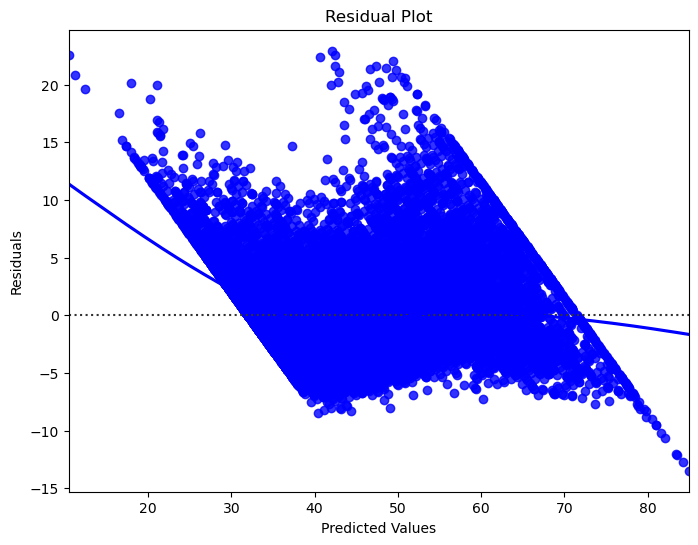

In [71]:


# ⚠️ Ensure you have defined your features (X) and target (y) before this step
# Example:
# X = df.drop("time_taken_minutes", axis=1)
# y = df["time_taken_minutes"]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Generate residuals
y_pred = model.predict(X_test)
residuals = y_test - y_pred

# Residual plot
plt.figure(figsize=(8,6))
# sns.residplot requires x=predicted values, y=actual values or residuals
sns.residplot(x=y_pred, y=residuals, lowess=True, color="blue")
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()
